# Sep ??st, 2021 (play nifti)

**Motivation**: fig 2 <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'graph_type': 'real',
}
mice = Mice(Config(128), load_preproc=True)
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

In [3]:
k = 6
p = 20
svinet = SVINET(mice, k, p, 'sub-SLC')
group_dir = get_svinet_group_dir(
    results_dir=mice.cfg.results_dir,
    k=k,
    p=p,
    graph_type=svinet_props.get('graph_type', 'real'),
)
print(group_dir)

current expt: 'p20'

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/gr
oup_results/real-p20-k6

In [4]:
available = [
    e for e in os.listdir(group_dir)
    if '(0.2,1.0;4)' in e
]
file = sorted(available, key=sort_date_latest)[-1]
group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

print(file)

group_bins(0.2,1.0;4)_(2021_09_15).npy

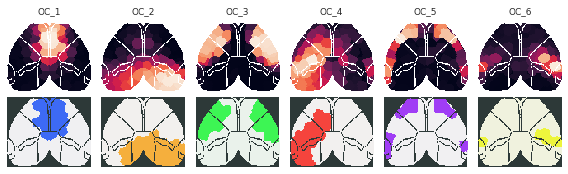

In [5]:
svinet = SVINET(mice, k, p, 'sub-SLC', verbose=False)
svinet.show(group['pi_avg'], figsize=(8, 2.5))

In [5]:
import ants
from register.register import organize_func_data, register_anat_data, reorient_arr, reset_ants_img, _load_prepare_ants

In [7]:
masks = np.load(pjoin(mice.cfg.masks_dir, 'sub-SLC07_ses-1_space-CCF_atlas3d-inv.npy'), allow_pickle=True)
masks = masks.item()

In [8]:
list(masks)

['roi', 'major', 'other']

In [9]:
list(masks['other'])

['root', 'CH', 'Isocortex', 'Isocortex_l', 'Isocortex_r']

In [10]:
arr = masks['other']['Isocortex'].copy()
iso_ants = ants.from_numpy(arr.astype('uint32'))
iso_ants = reset_ants_img(arr, spacing=0.2)
iso_ants

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (78, 64, 64)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [11]:
# ants.image_write(iso_ants, pjoin(mice.cfg.base_dir, 'iso.nii.gz'))

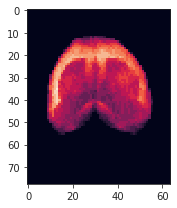

In [12]:
fig, ax = create_figure(1, 1, (4, 3))
ax.imshow(iso_ants.mean(1))
plt.show()

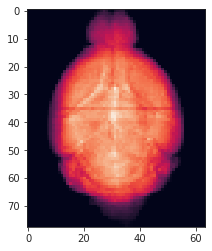

In [22]:
xxx = mice.T1w['sub-SLC07_ses-1'].get_data()
xxx = reorient_arr(xxx)
plt.imshow(xxx.mean(1))
plt.show()

xxx = ants.from_numpy(xxx)
xxx = reset_ants_img(xxx, spacing=0.2)

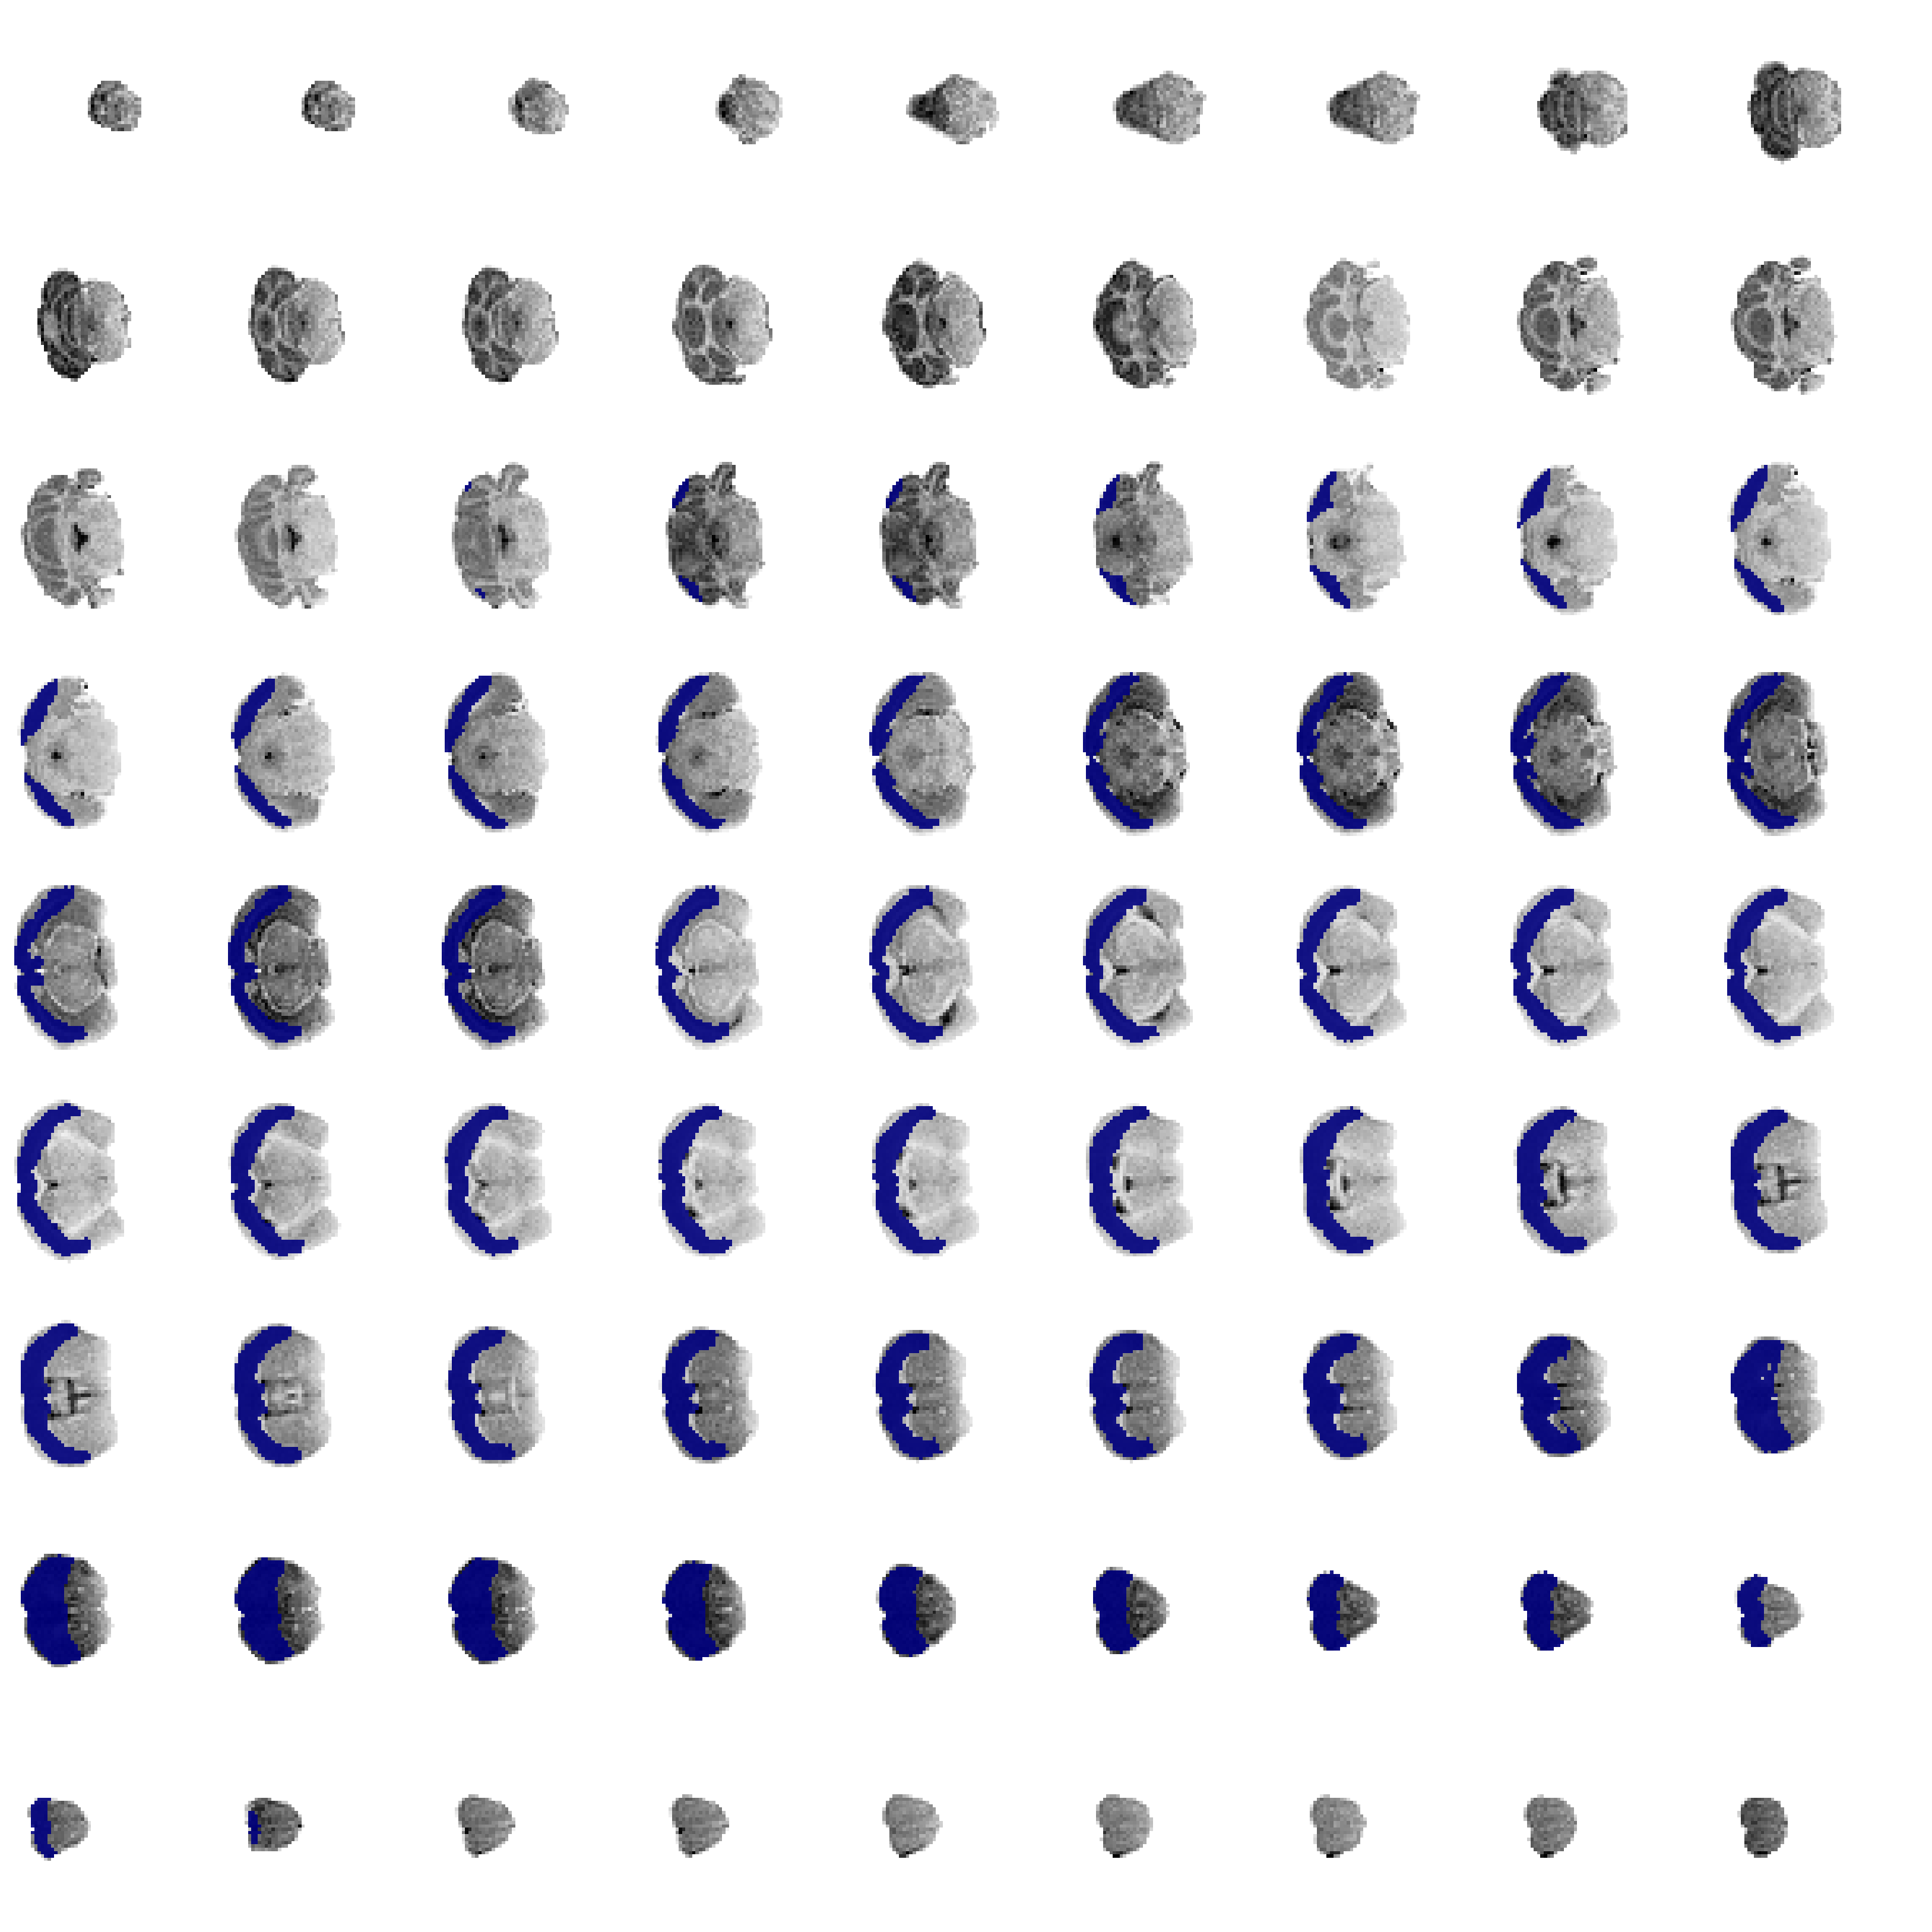

In [39]:
xxx.plot(
    overlay=iso_ants,
    cmap='Greys',
    axis=0,
    nslices=81,
    figsize=5,
)

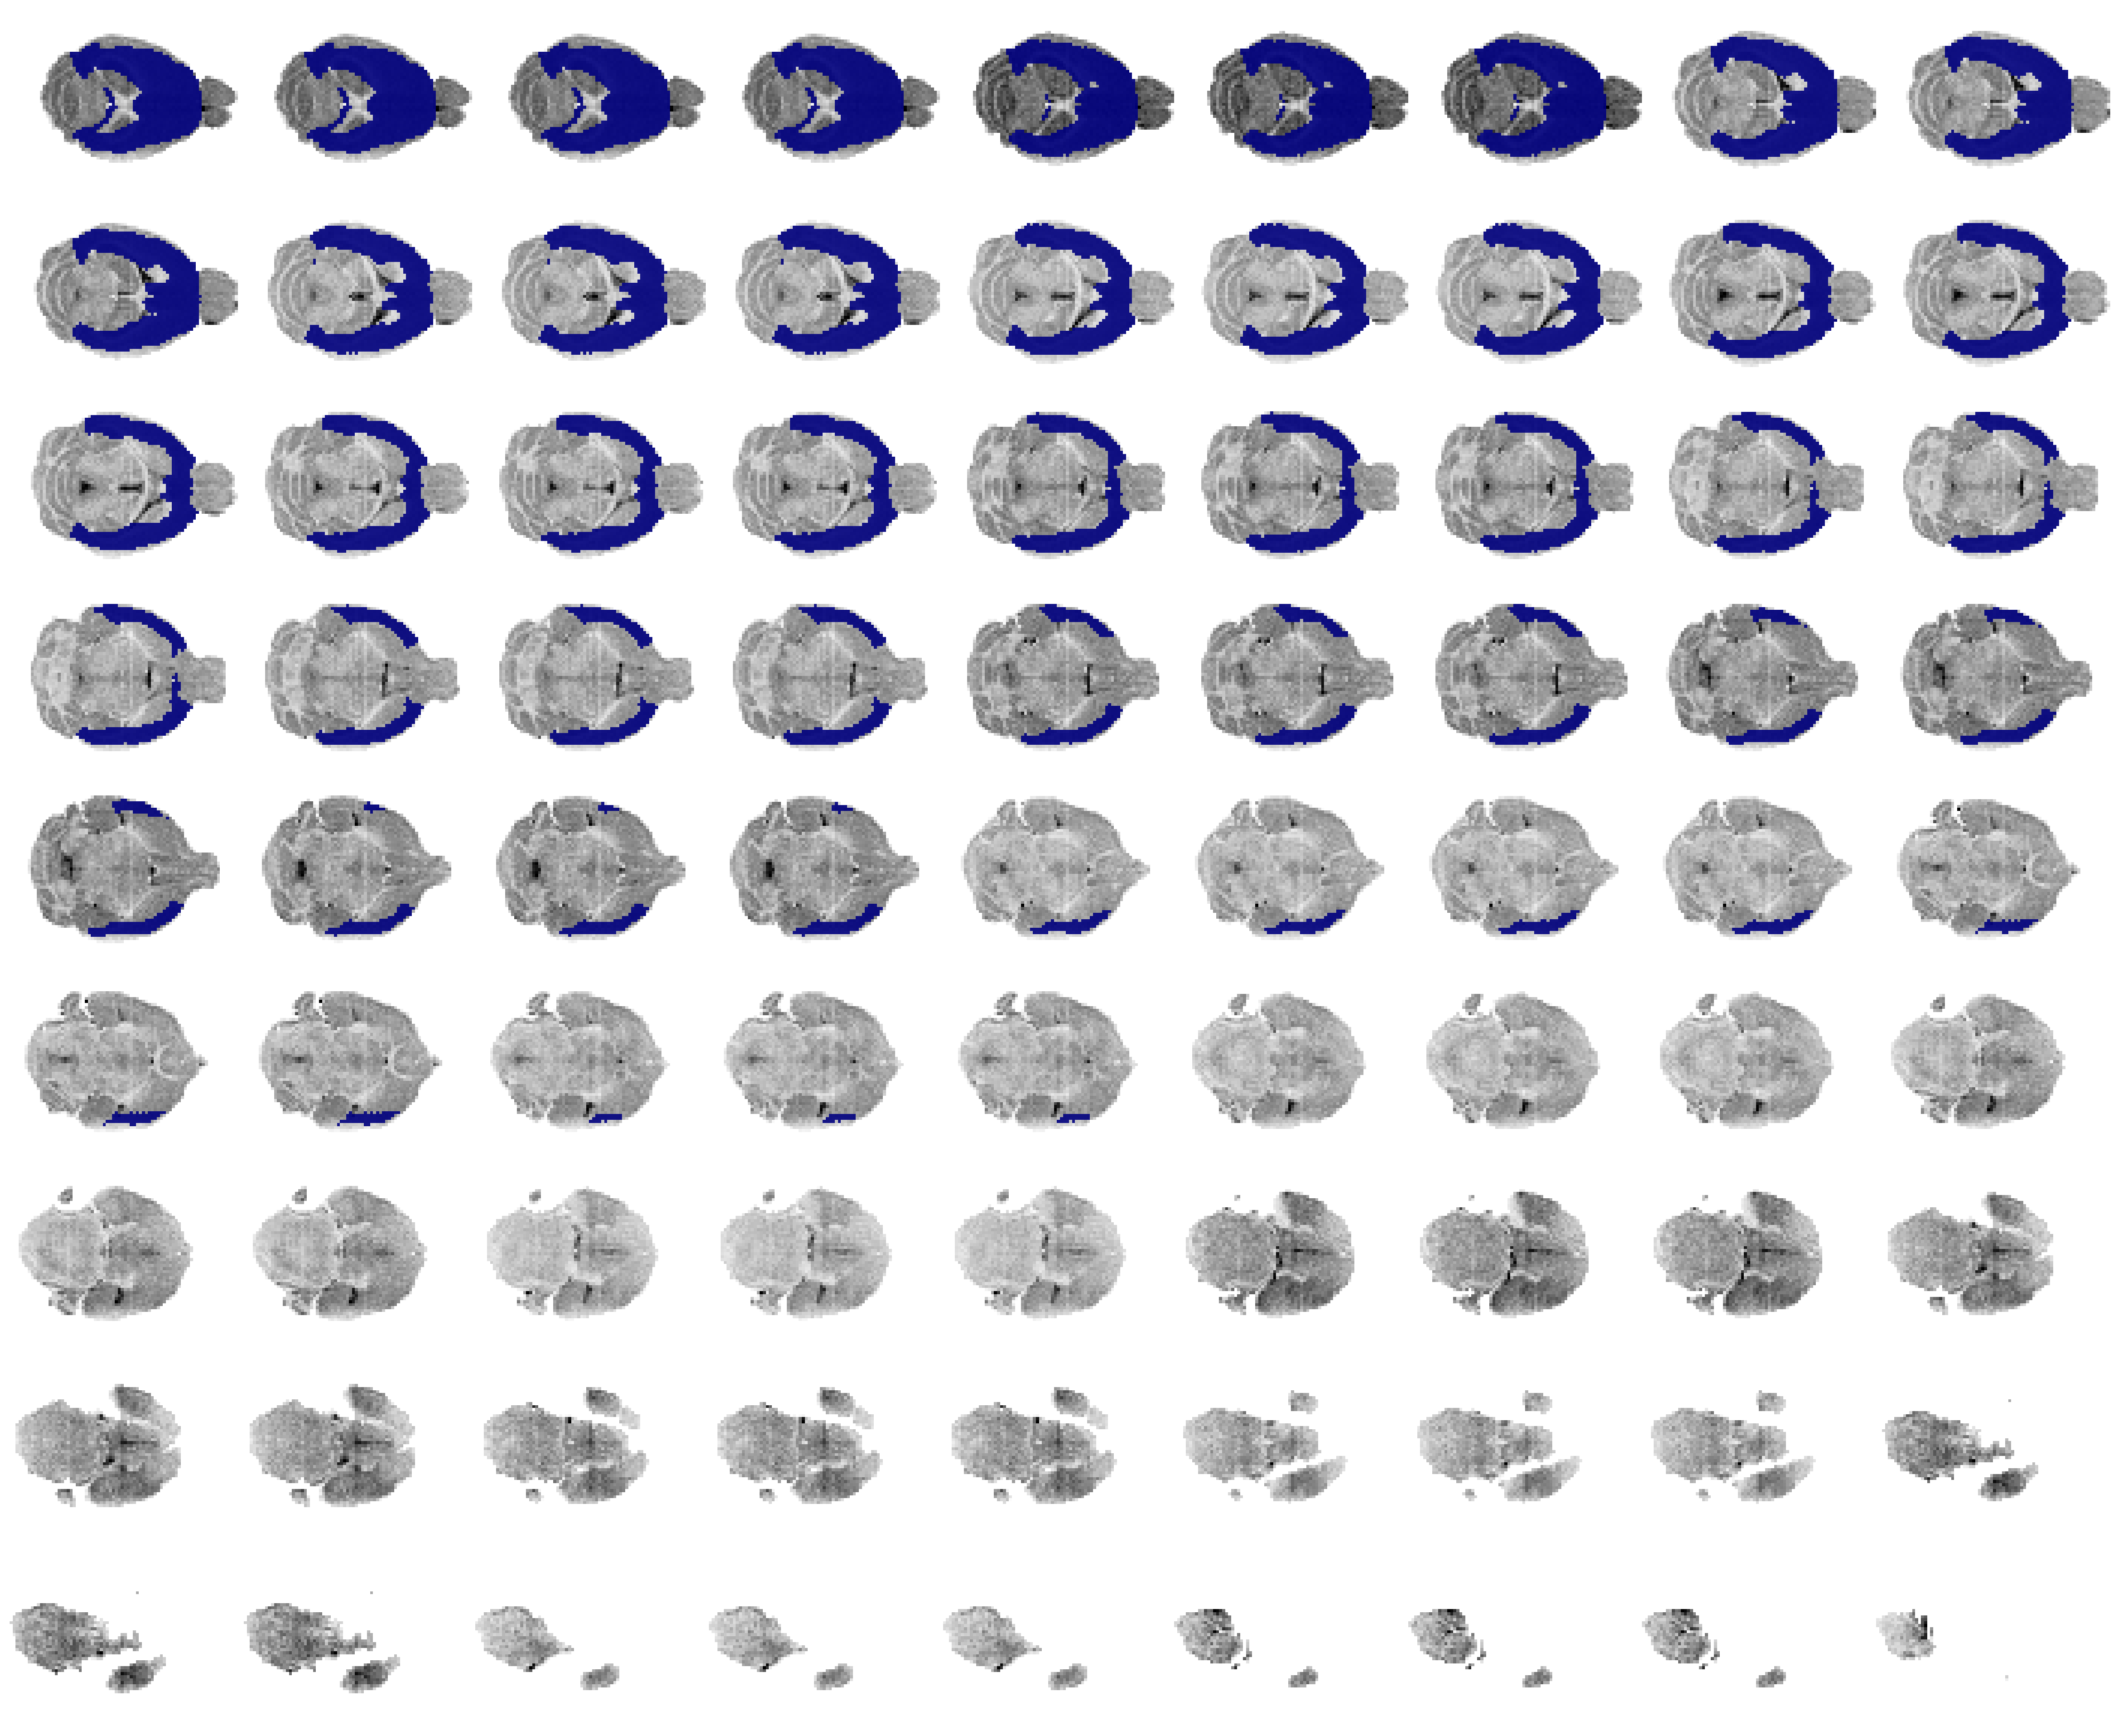

In [40]:
xxx.plot(
    overlay=iso_ants,
    cmap='Greys',
    axis=1,
    nslices=81,
    figsize=5,
)

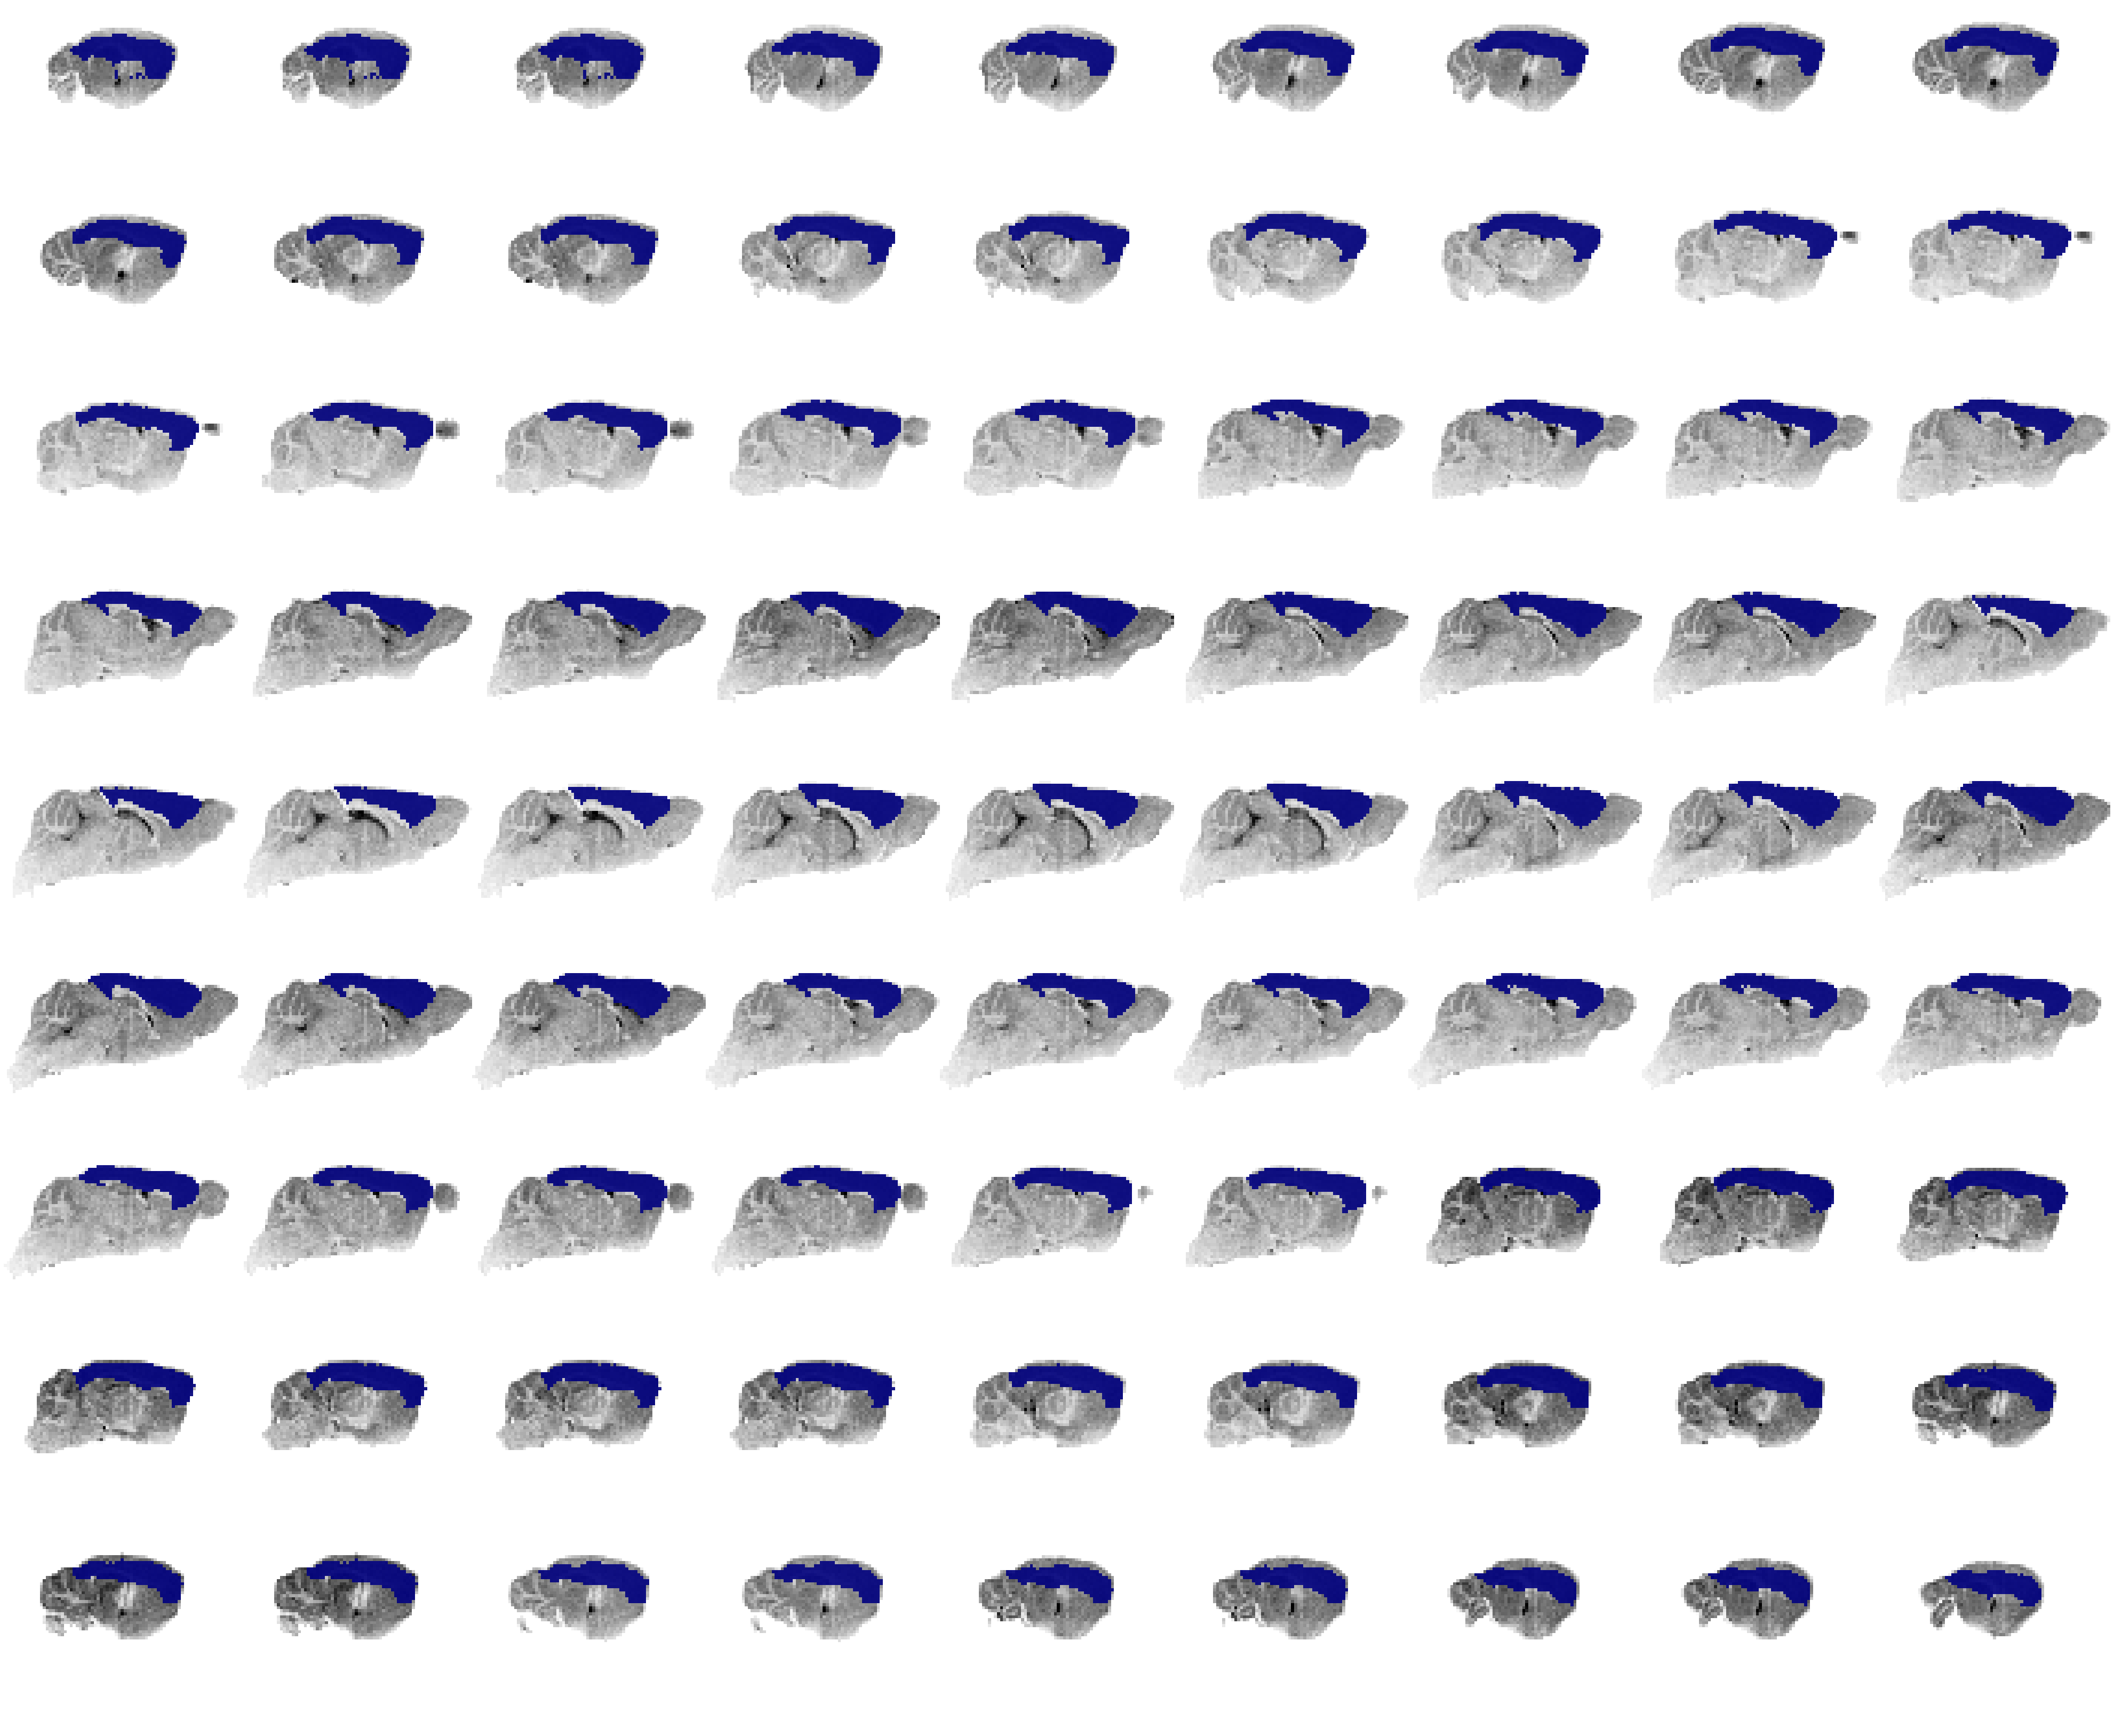

In [41]:
xxx.plot(
    overlay=iso_ants,
    cmap='Greys',
    axis=2,
    nslices=81,
    figsize=5,
)

In [6]:
in_house_name = 'Symmetric_N162'
type_of_transform = 'SyN'
interpolator = 'genericLabel'
space = 'CCF'
resolution = 100

In [42]:
key_space = f"space-{space}"
mice = mice if mice else Mice(load_preproc=True, load_df=False)
spacing_mm = resolution / 1000
yale_file = f"{in_house_name}_{spacing_mm:.2f}.nii.gz"
yale_file = pjoin(mice.cfg.base_dir, yale_file)
yale = _load_prepare_ants(yale_file, spacing_mm)
template = reset_ants_img(mice.allen['template'], spacing=spacing_mm)

tx_ccf2yale = [
    in_house_name, 'space-CCF',
    f"ants-{type_of_transform}-inv",
]
tx_ccf2yale = '_'.join(tx_ccf2yale)
tx_ccf2yale = list(filter(
    lambda f: tx_ccf2yale in f,
    os.listdir(mice.cfg.tx_dir)
))
tx_ccf2yale = [
    pjoin(mice.cfg.tx_dir, f)
    for f in sorted(tx_ccf2yale, reverse=False)
]

In [43]:
def _apply(m, tx_yale2indiv):
    warped_yale = ants.apply_transforms(
        fixed=yale,
        moving=reset_ants_img(m, spacing=spacing_mm),
        transformlist=tx_ccf2yale,
        interpolator=interpolator,
    )
    warped_indiv = ants.apply_transforms(
        fixed=indiv,
        moving=warped_yale,
        transformlist=tx_yale2indiv,
        interpolator=interpolator
    )
    return warped_indiv#.numpy().astype(bool)

In [44]:
for key, anat in mice.T1w.items():
    if key != 'sub-SLC06_ses-1':
        continue
    indiv = anat.get_data()
    if indiv is None:
        continue
    indiv = reorient_arr(indiv)
    indiv = reset_ants_img(indiv, spacing=spacing_mm * 2)

    tx_inv = '_'.join([key, key_space, 'ants-SyN-inv'])
    tx_inv = list(filter(
        lambda f: tx_inv in f,
        os.listdir(mice.cfg.tx_dir)
    ))
    tx_inv = [
        pjoin(mice.cfg.tx_dir, f)
        for f in sorted(tx_inv, reverse=False)
    ]
    print(tx_inv)

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/sub-SLC06_ses-1_space-CCF_ants-SyN-inv
.mat',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/sub-SLC06_ses-1_space-CCF_ants-SyN-inv
.nii.gz'
]

In [45]:
warped_indiv = _apply(template, tx_inv)

In [46]:
warped_indiv

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (78, 64, 64)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7e481eacdb20>

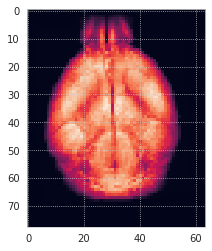

In [51]:
plt.imshow(warped_indiv.mean(1))

<matplotlib.image.AxesImage object at 0x7e481e921e50>

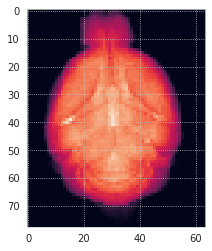

In [52]:
xxx = mice.T1w['sub-SLC06_ses-1'].get_data()
xxx = reorient_arr(xxx)
plt.imshow(xxx.mean(1))

In [10]:
ants.image_read(pjoin(mice.cfg.warped_dir, 'sub-SLC06_ses-1_space-CCF_T1w.nii.gz'))

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (132, 80, 114)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [6]:
register_anat_data(mice=mice, n_seeds=3)

  0%|          | 0/30 [00:00<?, ?it/s]

sub-SLC01_ses-1,        best rel mi: 0.458

  3%|▎         | 1/30 [00:33<15:58, 33.04s/it]

sub-SLC01_ses-2,        best rel mi: 0.453

  7%|▋         | 2/30 [01:07<15:50, 33.95s/it]

sub-SLC01_ses-3,        best rel mi: 0.454

 10%|█         | 3/30 [01:41<15:18, 34.00s/it]

sub-SLC02_ses-1,        best rel mi: 0.451

 13%|█▎        | 4/30 [02:17<14:59, 34.61s/it]

sub-SLC02_ses-2,        best rel mi: 0.44

 17%|█▋        | 5/30 [02:51<14:24, 34.57s/it]

sub-SLC02_ses-3,        best rel mi: 0.451

 20%|██        | 6/30 [03:26<13:48, 34.53s/it]

sub-SLC03_ses-1,        best rel mi: 0.462

 23%|██▎       | 7/30 [04:01<13:17, 34.69s/it]

sub-SLC03_ses-2,        best rel mi: 0.462

 27%|██▋       | 8/30 [04:37<12:51, 35.05s/it]

sub-SLC03_ses-3,        best rel mi: 0.457

 30%|███       | 9/30 [05:11<12:09, 34.72s/it]

sub-SLC04_ses-1,        best rel mi: 0.457

 33%|███▎      | 10/30 [05:46<11:36, 34.84s/it]

sub-SLC04_ses-2,        best rel mi: 0.468

 37%|███▋      | 11/30 [06:22<11:09, 35.24s/it]

sub-SLC04_ses-3,        best rel mi: 0.463

 40%|████      | 12/30 [06:56<10:26, 34.78s/it]

sub-SLC05_ses-1,        best rel mi: 0.454

 43%|████▎     | 13/30 [07:33<10:02, 35.46s/it]

sub-SLC05_ses-2,        best rel mi: 0.453

 47%|████▋     | 14/30 [08:07<09:20, 35.04s/it]

sub-SLC05_ses-3,        best rel mi: 0.463

 50%|█████     | 15/30 [08:41<08:41, 34.76s/it]

sub-SLC06_ses-1,        best rel mi: 0.462

 53%|█████▎    | 16/30 [09:14<08:01, 34.39s/it]

sub-SLC06_ses-2,        best rel mi: 0.448

 57%|█████▋    | 17/30 [09:49<07:30, 34.64s/it]

sub-SLC06_ses-3,        best rel mi: 0.448

 60%|██████    | 18/30 [10:24<06:53, 34.49s/it]

sub-SLC07_ses-1,        best rel mi: 0.445

 63%|██████▎   | 19/30 [10:59<06:21, 34.64s/it]

sub-SLC07_ses-2,        best rel mi: 0.458

 67%|██████▋   | 20/30 [11:34<05:48, 34.81s/it]

sub-SLC07_ses-3,        best rel mi: 0.448

 70%|███████   | 21/30 [12:08<05:12, 34.75s/it]

sub-SLC08_ses-1,        best rel mi: 0.457

 73%|███████▎  | 22/30 [12:43<04:37, 34.69s/it]

sub-SLC08_ses-2,        best rel mi: 0.461

 77%|███████▋  | 23/30 [13:18<04:04, 34.91s/it]

sub-SLC08_ses-3,        best rel mi: 0.445

 80%|████████  | 24/30 [13:53<03:29, 34.90s/it]

sub-SLC09_ses-1,        best rel mi: 0.451

 83%|████████▎ | 25/30 [14:28<02:54, 34.89s/it]

sub-SLC09_ses-2,        best rel mi: 0.453

 87%|████████▋ | 26/30 [15:06<02:22, 35.72s/it]

sub-SLC09_ses-3,        best rel mi: 0.467

 90%|█████████ | 27/30 [15:41<01:47, 35.67s/it]

sub-SLC10_ses-1,        best rel mi: 0.459

 93%|█████████▎| 28/30 [16:17<01:11, 35.79s/it]

sub-SLC10_ses-2,        best rel mi: 0.447

 97%|█████████▋| 29/30 [16:54<00:35, 35.98s/it]

sub-SLC10_ses-3,        best rel mi: 0.416

100%|██████████| 30/30 [17:31<00:00, 35.06s/it]


## ---

In [4]:
import ants
from register.register import reorient_arr, reset_ants_img, register_in_house

In [34]:
df_tx, best_tx_yale2ccf = register_in_house('Symmetric_N162', mice=mice, n_seeds=3)

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
df_tx.iloc[[df_tx.perf.argmax()]]

resolution 
 seed 
 grad 
 bins 
 type 
 perf 
 tx 
 
 
 
 
 12 
 100 
 2 
 1.3 
 32 
 SyN 
 0.492486 
 {'warpedmovout': ANTsImage (RAI)
 Pixel Type ...

<AxesSubplot:xlabel='grad', ylabel='perf'>

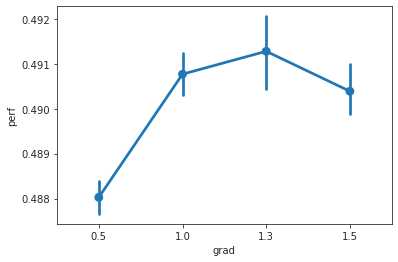

In [36]:
sns.pointplot(data=df_tx, x='grad', y='perf')

In [37]:
_df = df_tx.groupby(['grad', 'bins', 'type']).mean()
best_params = _df.iloc[[_df.perf.argmax()]]
best_params = dict(zip(
    best_params.index.names,
    best_params.index.values[0]
))
cond = [
    np.array(df_tx[k] == v)
    for k, v in best_params.items()
]
# noinspection PyTypeChecker
cond = functools.reduce(np.logical_and, cond)
_df = df_tx.loc[cond]
_df = _df.iloc[[_df.perf.argmax()]]
# best_tx_yale2ccf = _df.tx.values.item()

In [38]:
_df

resolution 
 seed 
 grad 
 bins 
 type 
 perf 
 tx 
 
 
 
 
 12 
 100 
 2 
 1.3 
 32 
 SyN 
 0.492486 
 {'warpedmovout': ANTsImage (RAI)
 Pixel Type ...

In [27]:
"""best_hyperparams = dict(zip(
    best_hyperparams.index.names,
    best_hyperparams.index.values[0]
))
best_hyperparams"""

{'grad': 1.0, 'bins': 32, 'type': 'SyN'}

In [28]:
"""cond = [
    np.array(df_tx[k] == v)
    for k, v in best_hyperparams.items()
]
cond = functools.reduce(np.logical_and, cond)
_df = df_tx.loc[cond]
_df = _df.iloc[[_df.perf.argmax()]]
_df"""

resolution 
 seed 
 grad 
 bins 
 type 
 perf 
 tx 
 
 
 
 
 48 
 100 
 32 
 1.0 
 32 
 SyN 
 0.492417 
 {'warpedmovout': ANTsImage (RAI)
 Pixel Type ...

In [55]:
tx_yale2ccf = [
    'Symmetric_N162', 'space-CCF',
    f"ants-SyN-fwd",
]
tx_yale2ccf = '_'.join(tx_yale2ccf)
tx_yale2ccf = list(filter(
    lambda f: tx_yale2ccf in f,
    os.listdir(mice.cfg.tx_dir)
))
tx_yale2ccf = [
    pjoin(mice.cfg.tx_dir, f)
    for f in sorted(tx_yale2ccf, reverse=True)
]
tx_yale2ccf

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-fwd.nii.gz',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-fwd.mat'
]

### Now do moving

In [13]:
resolution = 100
in_house_name = 'Symmetric_N162'

spacing_mm = resolution / 1000
yale_file = f"{in_house_name}_{spacing_mm:.2f}.nii.gz"
yale_file = pjoin(mice.cfg.base_dir, yale_file)
yale = _load_prepare_ants(yale_file, spacing_mm)
template = reset_ants_img(mice.allen['template'], spacing=spacing_mm)

yale, template

(
    ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
,
    ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (132, 80, 114)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

)

In [14]:
anat = mice.T1w['sub-SLC06_ses-1']
moving = anat.get_data()
moving = reorient_arr(moving)
moving = reset_ants_img(moving, spacing=0.2)
moving

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (78, 64, 64)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [58]:
seeds = [2**i for i in range(3)]

_txs = []
_perf = []
for seed in tqdm(seeds):
    tx = ants.registration(
        fixed=yale,
        moving=moving,
        mask=moving.get_mask(),
        type_of_transform='SyN',
        verbose=True,
        grad_step=1.0,
        random_seed=seed,
    )
    warped = ants.apply_transforms(
        fixed=yale,
        moving=moving,
        transformlist=tx['fwdtransforms'],
        interpolator='linear',
    )
    mi = ants.image_mutual_information(yale, warped)
    mi_base = ants.image_mutual_information(yale, yale)
    _perf.append(mi / mi_base)
    _txs.append(tx)

print(np.argmax(_perf), _perf[np.argmax(_perf)])

  0%|          | 0/3 [00:00<?, ?it/s]

2 0.7350436993801447

In [59]:
_perf

[0.7202207897560498, 0.7345631254825565, 0.7350436993801447]

In [60]:
best_tx = _txs[np.argmax(_perf)]

In [61]:
warped_yale = ants.apply_transforms(
    fixed=yale,
    moving=moving,
    transformlist=best_tx['fwdtransforms'],
    interpolator='linear',
)
mi = ants.image_mutual_information(yale, warped_yale)
mi_base = ants.image_mutual_information(yale, yale)
mi / mi_base

0.7350436993801447

In [62]:
warped_ccf = ants.apply_transforms(
    fixed=template,
    moving=warped_yale,
    transformlist=tx_yale2ccf,
    interpolator='linear',
)
mi = ants.image_mutual_information(template, warped_ccf)
mi_base = ants.image_mutual_information(template, template)
mi / mi_base

0.453232351189077

In [53]:
for src in best_tx_yale2ccf['fwdtransforms']:
    ext = '.'.join(src.split('.')[1:])
    shutil.copyfile(
        src=src, dst=f"/home/hadi/Documents/test-fwd.{ext}")

In [42]:
best_tx_yale2ccf['fwdtransforms']

['/tmp/tmpe2yhmx2e1Warp.nii.gz', '/tmp/tmpe2yhmx2e0GenericAffine.mat']

In [43]:
tx_yale2ccf

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-fwd.mat',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-fwd.nii.gz'
]

In [44]:
testtest = [tx_yale2ccf[1], tx_yale2ccf[0]]

In [45]:
testtest

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-fwd.nii.gz',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-fwd.mat'
]

In [54]:
warped_ccf = ants.apply_transforms(
    fixed=template,
    moving=warped_yale,
    transformlist=testtest,
    interpolator='linear',
)

mi = ants.image_mutual_information(template, warped_ccf)
mi_base = ants.image_mutual_information(template, template)
mi / mi_base

0.4536662095006584

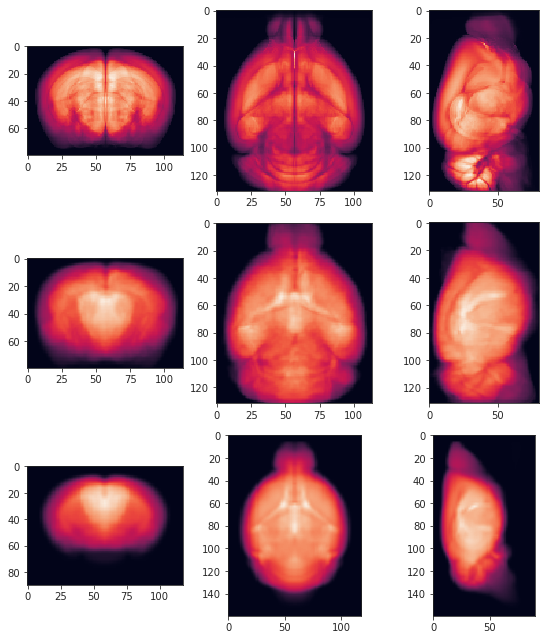

In [41]:
fig, axes = create_figure(3, 3, (8, 9))
for i in range(3):
    axes[0, i].imshow(template.mean(i))
    axes[1, i].imshow(warped_ccf.mean(i))
    axes[2, i].imshow(yale.mean(i))

## ------------------------------------
---

In [15]:
os.listdir(mice.cfg.base_dir)

[
    'processed',
    '_label_names.rtf',
    'Symmetric_N162_0.275.nii.gz',
    'Symmetric_N162_0.10.nii.gz',
    'Symmetric_N162_0.20.nii.gz',
    'mouseatlas_2020.json',
    'Symmetric_N162_0.05.nii.gz',
    'atlases_templates'
]

In [16]:
file = pjoin(mice.cfg.base_dir, 'Symmetric_N162_0.10.nii.gz')
# file = pjoin(mice.cfg.base_dir, 'N162_medium_symm_0.2.nii.gz')

img = nib.load(file)
arr = img.get_fdata()
arr.shape

(118, 90, 160)

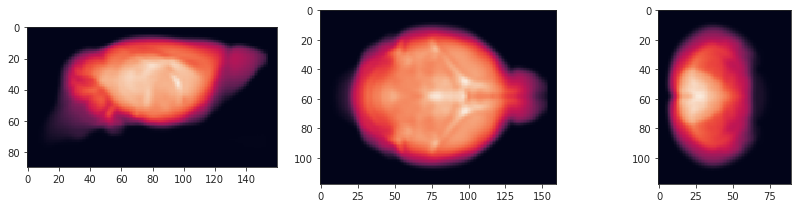

In [17]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(arr.mean(i))

In [18]:
import ants
img_ants = ants.image_read(file)
img_ants

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [19]:
iso_ccf = mice.allen['isocortex_mask']
iso_ccf.shape

(132, 80, 114)

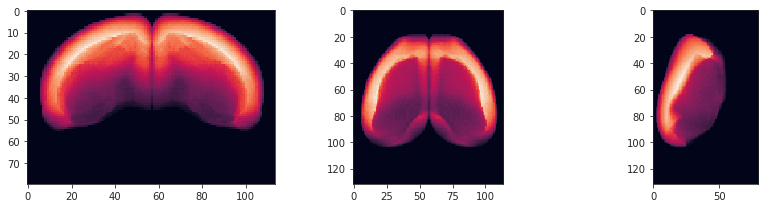

In [20]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(iso_ccf.mean(i))

In [21]:
from register.register import reorient_arr, reset_ants_img

In [22]:
iso_ccf = reorient_arr(iso_ccf, (2, 1, 0))
iso_ccf = iso_ccf[..., ::-1]

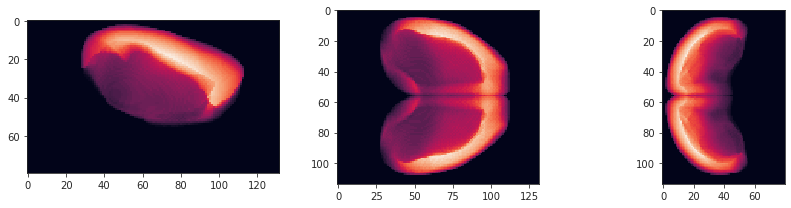

In [23]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(iso_ccf.mean(i))

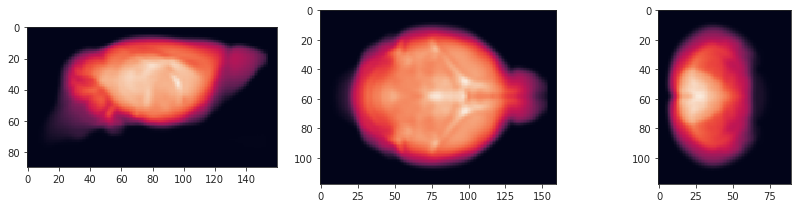

In [24]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(arr.mean(i))

In [25]:
img_ants

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (118, 90, 160)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [27]:
iso_ccf_ants = ants.from_numpy(
    data=iso_ccf.astype('uint32'),
    origin=img_ants.origin,
    spacing=img_ants.spacing,
    direction=img_ants.direction,
)
iso_ccf_ants

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (114, 80, 132)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [43]:
ants.image_write(iso_ccf_ants, pjoin(mice.cfg.base_dir, 'iso_ccf_ants.nii.gz'))

In [44]:
iso_ccf_nib = ants.to_nibabel(iso_ccf_ants)
iso_ccf_nib.set_data_dtype(img.get_data_dtype())
iso_ccf_nib.set_qform(img.get_qform())
iso_ccf_nib.set_sform(img.get_sform())
nib.save(iso_ccf_nib, pjoin(mice.cfg.base_dir, 'iso_ccf_nib.nii.gz'))

In [46]:
medium = nib.load(pjoin(mice.cfg.base_dir, 'N162_medium_symm_0.1.nii.gz'))

In [50]:
medium.get_data_dtype()

dtype('<i2')

array([[-0.1,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  1. ]])

In [48]:
medium.get_sform()

array([[-0.1,  0. ,  0. ,  0. ],
       [ 0. , -0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. ,  1. ]])

In [49]:
medium.get_qform()

array([[-0.1       ,  0.        ,  0.        , -6.4000001 ],
       [ 0.        , -0.1       ,  0.        ,  6.20000029],
       [ 0.        ,  0.        ,  0.1       , -7.80000019],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [52]:
hdr = medium.get_header()

In [53]:
hdr.get_qform()

array([[-0.1       ,  0.        ,  0.        , -6.4000001 ],
       [ 0.        , -0.1       ,  0.        ,  6.20000029],
       [ 0.        ,  0.        ,  0.1       , -7.80000019],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [86]:
iso_ccf_nib_2 = nib.Nifti1Image(
    mice.allen['template'].astype(medium.get_data_dtype()),
    affine=medium.get_affine(),
    header=medium.get_header(),
)
nib.save(iso_ccf_nib_2, pjoin(mice.cfg.base_dir, 'temp_ccf_nib_2.nii.gz'))

In [7]:
in_house_name = 'Symmetric_N162'
type_of_transform = 'SyN'

tx_ccf2yale = [
    in_house_name, 'space-CCF',
    f"ants-{type_of_transform}-inv",
]
tx_ccf2yale = '_'.join(tx_ccf2yale)
tx_ccf2yale = list(filter(
    lambda f: tx_ccf2yale in f,
    os.listdir(mice.cfg.tx_dir)
))
tx_ccf2yale = [
    pjoin(mice.cfg.tx_dir, f)
    for f in sorted(tx_ccf2yale, reverse=False)
]
tx_ccf2yale

[
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-inv.mat',
    '/home/hadi/Documents/Ca-fMRI/processed/transforms/Symmetric_N162_space-CCF_ants-SyN-inv.nii.gz'
]

In [8]:
spacing_mm = resolution / 1000
yale_file = f"{in_house_name}_{spacing_mm:.2f}.nii.gz"
yale_file = pjoin(mice.cfg.base_dir, yale_file)
yale = _load_prepare_ants(yale_file, spacing_mm)
template = reset_ants_img(mice.allen['template'], spacing=0.1)

In [10]:
ccf_hadi = ants.apply_transforms(
    fixed=yale,
    moving=template,
    transformlist=tx_ccf2yale,
    interpolator='linear',
)
ccf_hadi

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [75]:
ants.image_write(ccf_hadi, pjoin(mice.cfg.base_dir, 'temp_ccf_hadi.nii.gz'))

In [87]:
over = ants.image_read(pjoin(mice.cfg.base_dir, 'overlay0.nii.gz'))

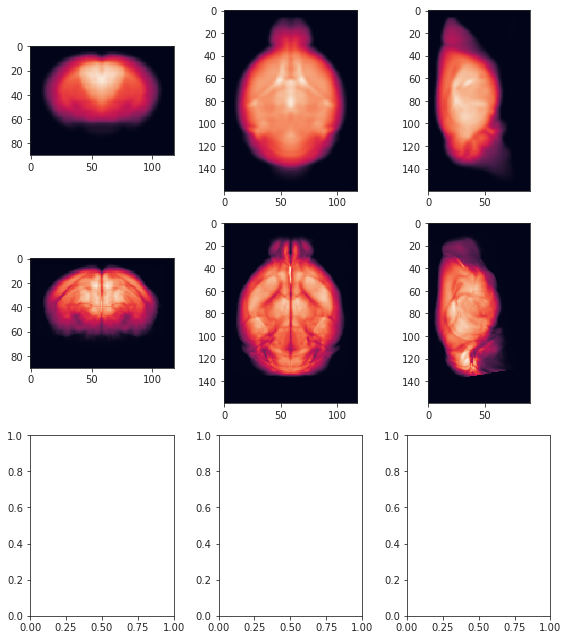

In [11]:
fig, axes = create_figure(3, 3, (8, 9))
for i in range(3):
    axes[0, i].imshow(yale.mean(i))
    axes[1, i].imshow(ccf_hadi.mean(i))
    # axes[2, i].imshow(over.mean(i))

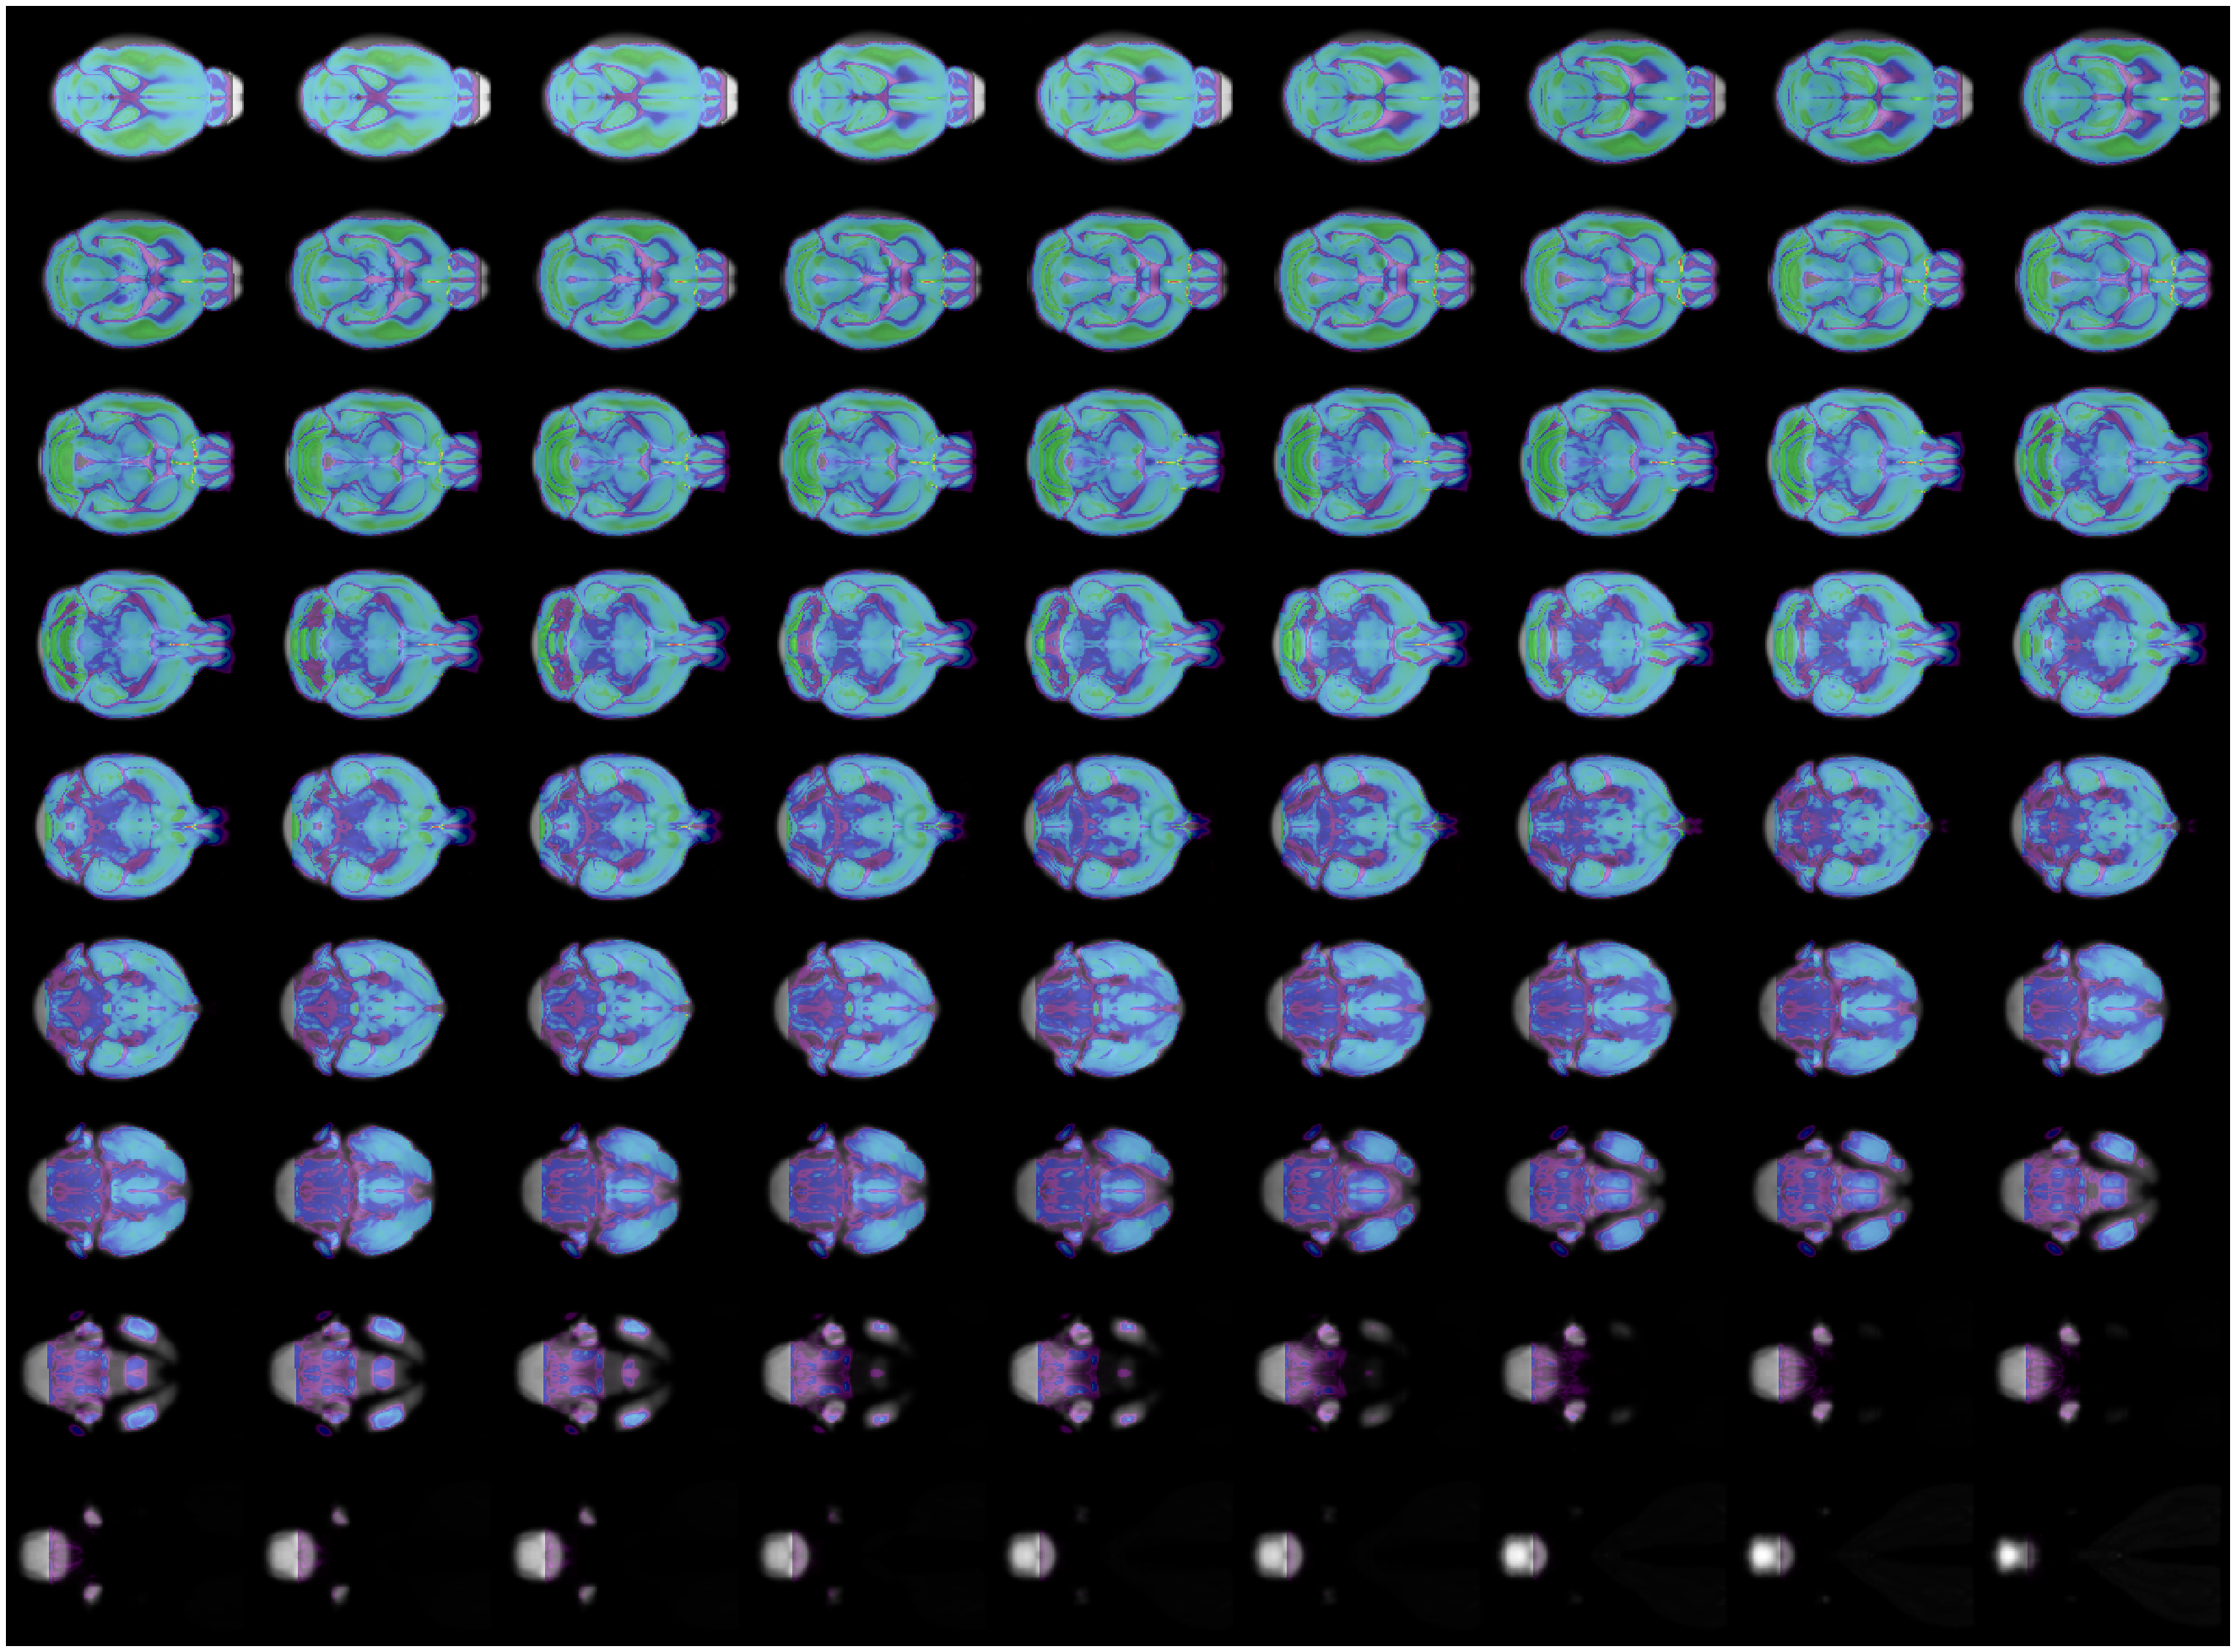

In [12]:
yale.plot(
    overlay=ccf_hadi,
    overlay_cmap='nipy_spectral',
    overlay_alpha=0.5,
    axis=1,
    nslices=81,
    figsize=3,
)

In [151]:
"""yale_mask = yale.get_mask()
custom_mask = np.ones_like(yale_mask.numpy())
custom_mask[:12] = 0
custom_mask[-20:] = 0

yale_mask *= custom_mask
yale_mask"""

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [13]:
seeds = [2**i for i in range(3)]

_txs = []
_perf = []
for seed in tqdm(seeds):
    tx = ants.registration(
        fixed=template,
        moving=yale,
        mask=yale.get_mask(),
        type_of_transform='ElasticSyN',
        grad_step=1.0,
        random_seed=seed,
        verbose=True,
    )
    warped = ants.apply_transforms(
        fixed=yale,
        moving=template,
        transformlist=tx['invtransforms'],
        interpolator='linear',
    )
    mi = ants.image_mutual_information(yale, warped)
    mi_base = ants.image_mutual_information(yale, yale)
    score = mi / mi_base
    print(seed, score)
    _perf.append(score)
    _txs.append(tx)

  0%|          | 0/3 [00:00<?, ?it/s]

1 0.4917995963759468

2 0.49129915625182813

4 0.4909007170763232

In [14]:
_perf

[0.4917995963759468, 0.49129915625182813, 0.4909007170763232]

In [15]:
_perf[np.argmax(_perf)]

0.4917995963759468

In [16]:
best_tx = _txs[np.argmax(_perf)]

In [17]:
ccf_hadi = ants.apply_transforms(
    fixed=yale,
    moving=template,
    transformlist=best_tx['invtransforms'],
    interpolator='linear',
)
ccf_hadi

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

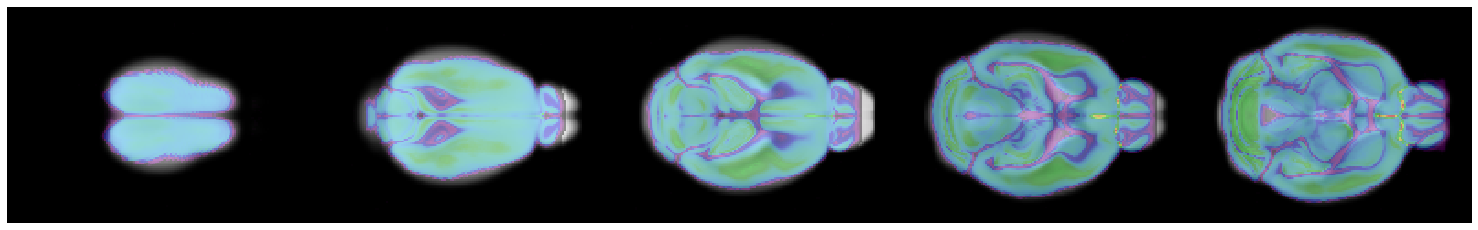

In [19]:
yale.plot(
    overlay=ccf_hadi,
    overlay_cmap='nipy_spectral',
    overlay_alpha=0.4,
    axis=1,
    slices=[10, 15, 20, 25, 30],
    figsize=3,
)

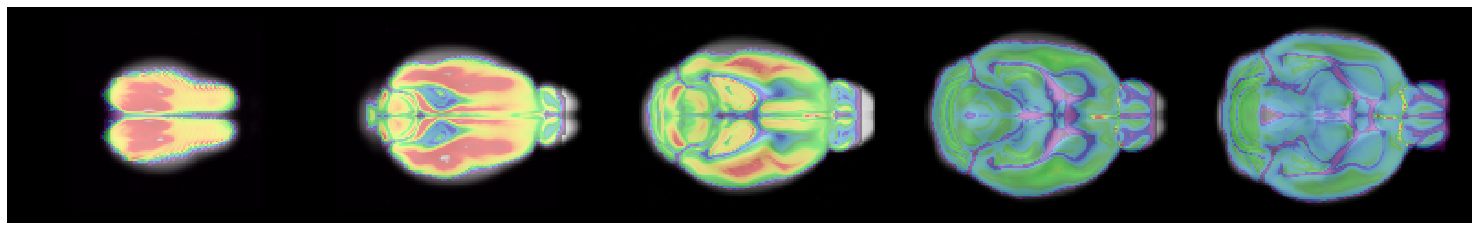

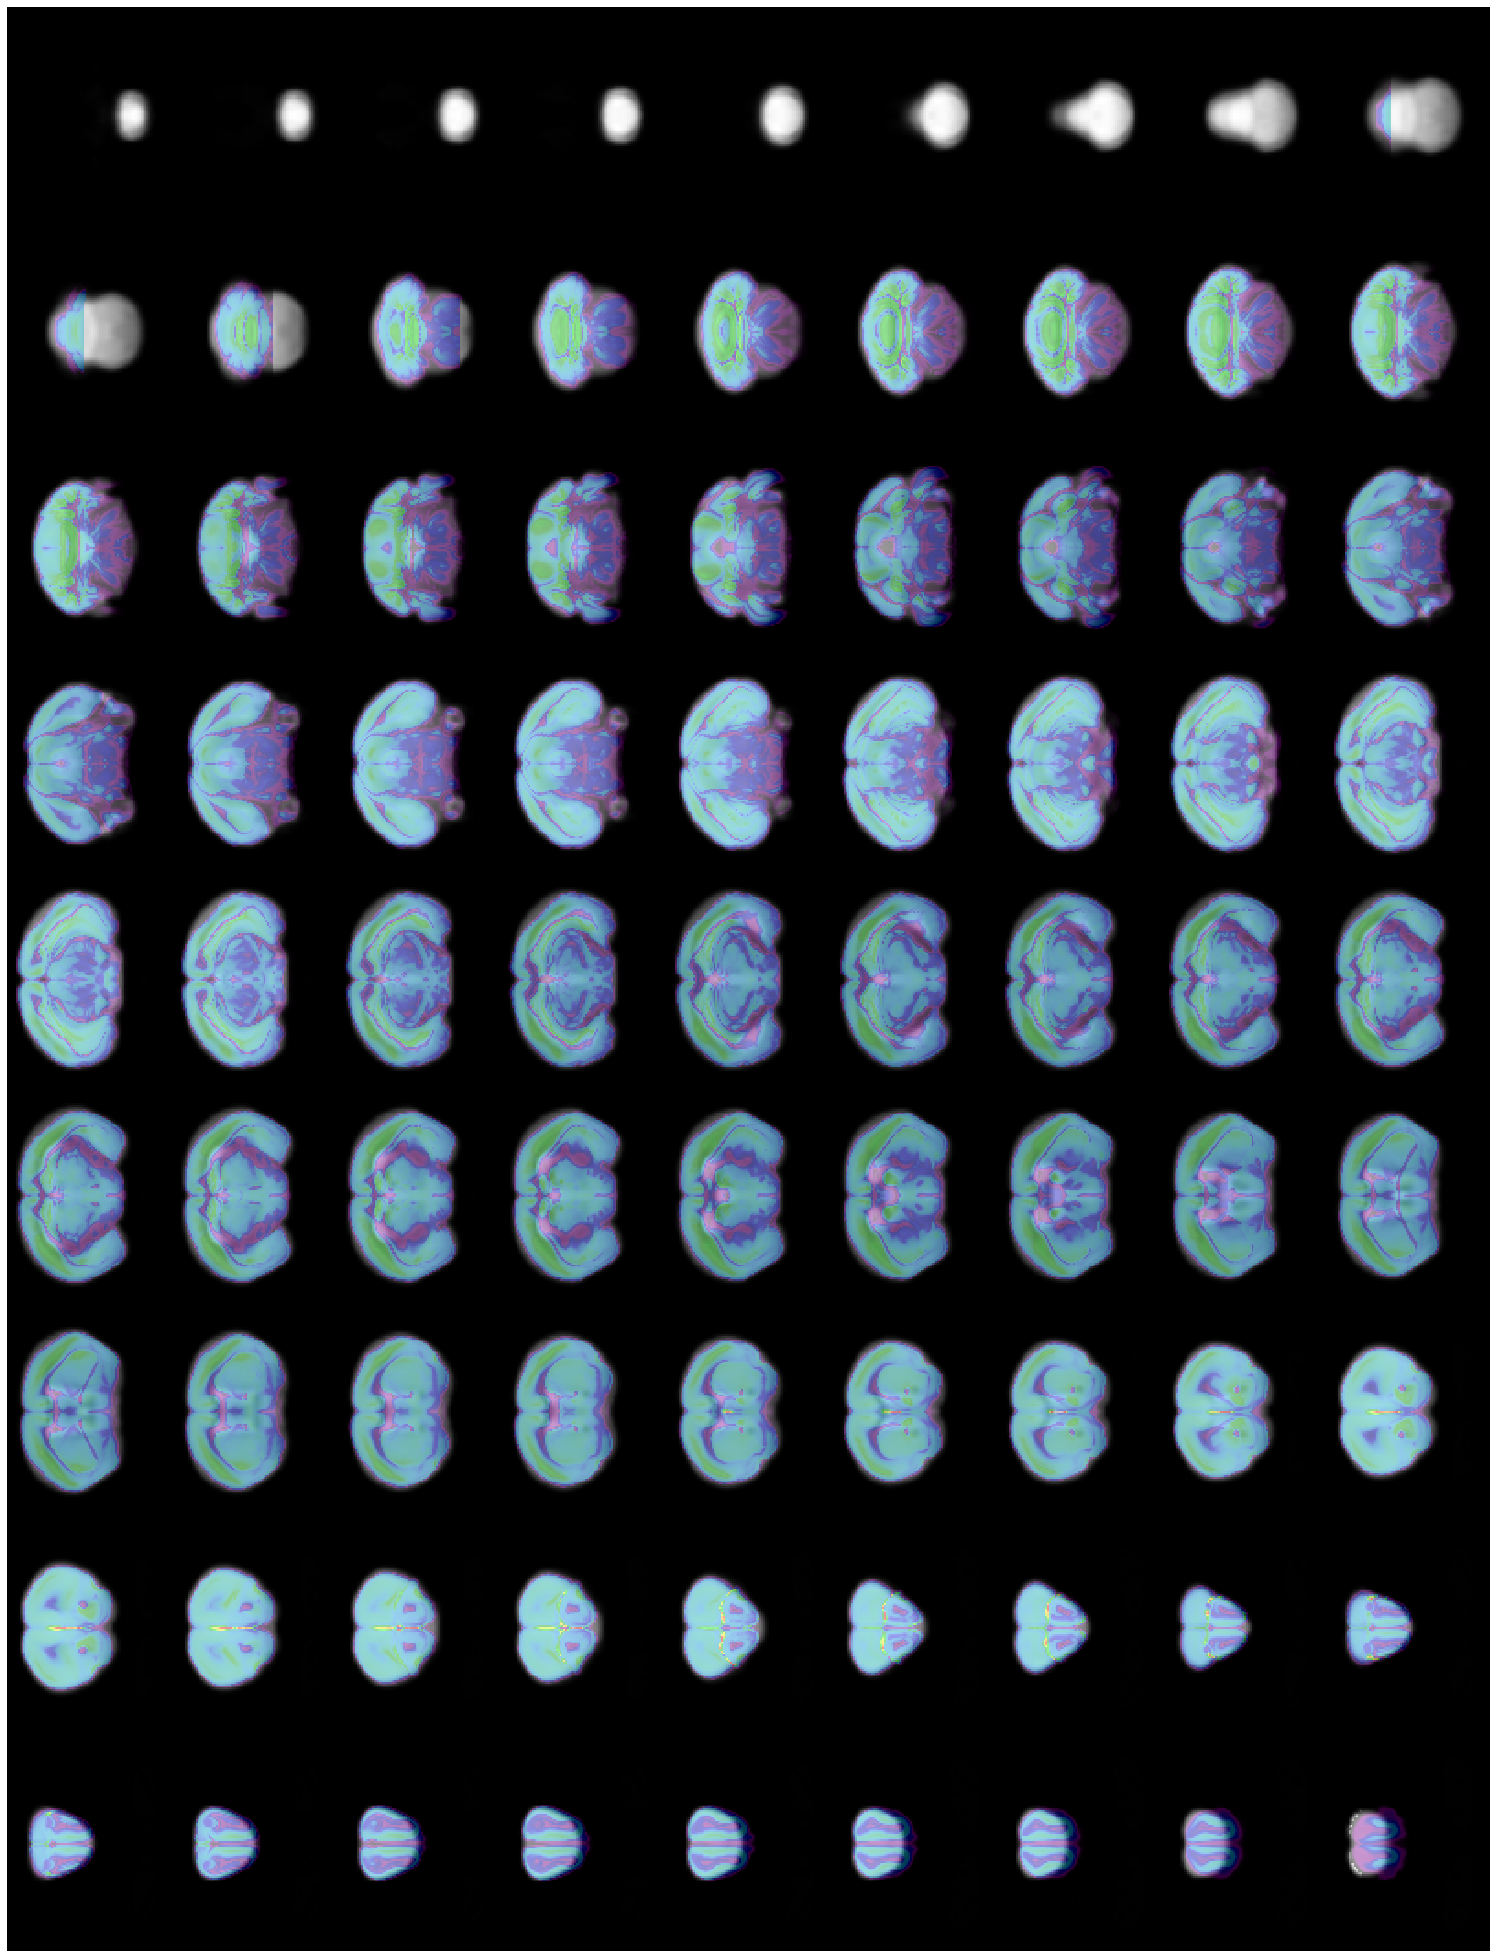

In [20]:
yale.plot(
    overlay=ccf_hadi,
    overlay_cmap='nipy_spectral',
    overlay_alpha=0.4,
    axis=0,
    nslices=81,
    # slices=[10, 15, 20, 25, 30],
    figsize=3,
)

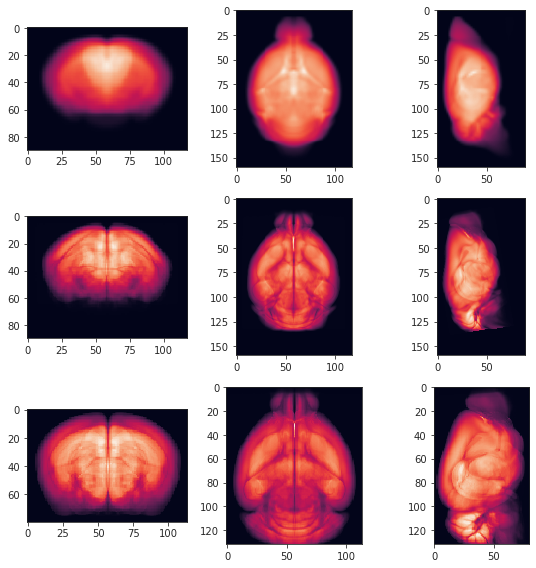

In [21]:
fig, axes = create_figure(3, 3, (8, 8))
for i in range(3):
    axes[0, i].imshow(yale.mean(i))
    axes[1, i].imshow(ccf_hadi.mean(i))
    axes[2, i].imshow(template.mean(i))

In [44]:
load = pjoin(mice.cfg.base_dir, 'overlay0.nii.gz')
# load = pjoin(mice.cfg.base_dir, 'N162_medium_symm_0.2.nii.gz')
over = nib.load(load)
over_arr = over.get_fdata()
over.shape

(118, 90, 160)

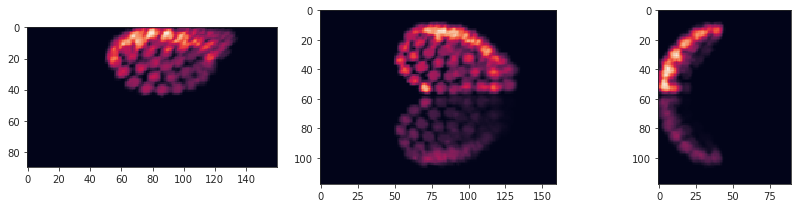

In [45]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(over_arr.mean(i))

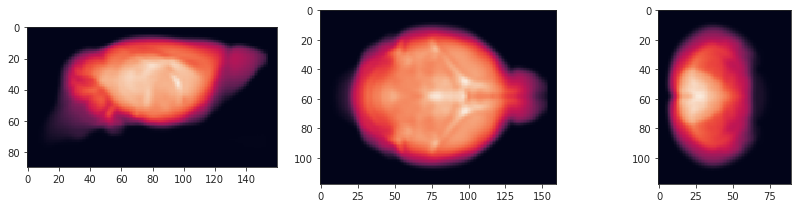

In [46]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(arr.mean(i))

In [47]:
temp = mice.allen['template'].copy()
temp.shape

(132, 80, 114)

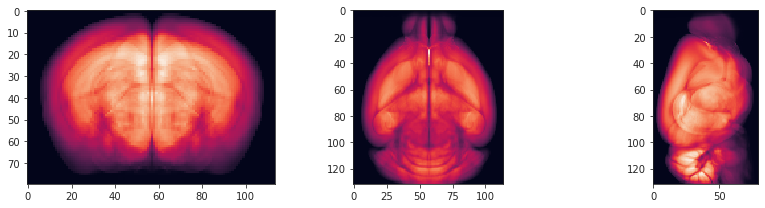

In [48]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(temp.mean(i))

In [49]:
yale_n162 = reorient_arr(arr)

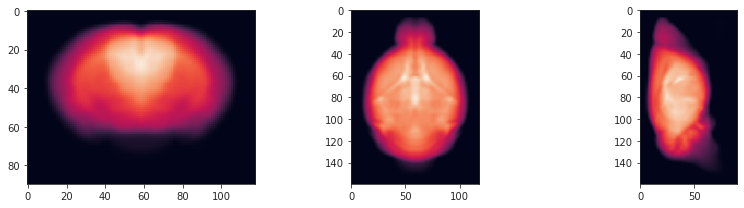

In [50]:
fig, axes = create_figure(1, 3, (12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(yale_n162.mean(i))

In [55]:
anat = mice.T1w['sub-SLC07_ses-1']
moving = anat.get_data()
moving = reorient_arr(moving)
moving = reset_ants_img(moving, spacing=0.2)
moving.shape

(78, 64, 64)

In [57]:
moving

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (78, 64, 64)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [58]:
yale_n162_ants = reset_ants_img(yale_n162, spacing=0.1)
yale_n162_ants

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [72]:
temp = mice.allen['template'].copy()
temp = reset_ants_img(temp, spacing=0.1)
temp

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (132, 80, 114)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

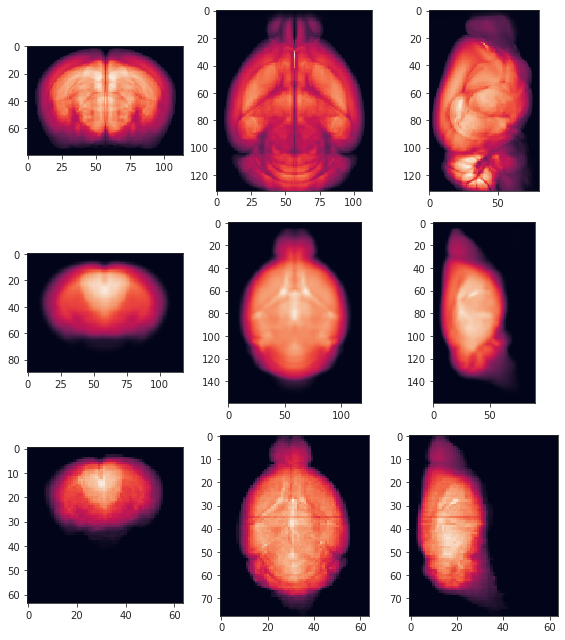

In [73]:
fig, axes = create_figure(3, 3, (8, 9))
for i in range(3):
    axes[0, i].imshow(temp.mean(i))
    axes[1, i].imshow(yale_n162_ants.mean(i))
    axes[2, i].imshow(moving.mean(i))

In [318]:
x = mice.bold_preproc['sub-SLC07_ses-1_run-1'].get_data()

In [322]:
x.shape

(64, 64, 78, 600)

In [323]:
x = reorient_arr(x)
x.shape

(78, 64, 64, 600)

<matplotlib.image.AxesImage object at 0x7f5eb1b045b0>

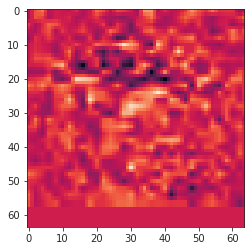

In [327]:
plt.imshow(x[60, ..., 120])

In [332]:
mask = mice.mask3d['sub-SLC07_ses-1'].get_data()
mask.shape

(64, 64, 78)

In [333]:
mask = reorient_arr(mask)
mask.shape

(78, 64, 64)

<matplotlib.image.AxesImage object at 0x7e80ccea6a30>

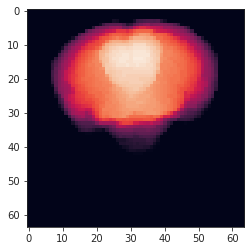

In [334]:
plt.imshow(mask.mean(0))

<matplotlib.image.AxesImage object at 0x7da276b69f10>

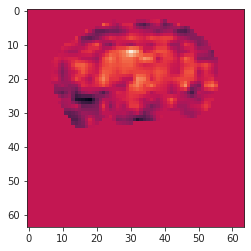

In [356]:
plt.imshow((x[..., 14] * mask)[40])

In [357]:
fixed.shape, moving.shape

((81, 46, 60), (78, 64, 64))

In [62]:
seeds = [2**i for i in range(20)]

_txs = []
_perf = []
for seed in tqdm(seeds):
    tx = ants.registration(
        fixed=yale_n162_ants,
        moving=moving,
        mask=moving.get_mask(),
        type_of_transform='SyN',
        verbose=True,
        random_seed=seed,
    )
    warped = ants.apply_transforms(
        fixed=yale_n162_ants,
        moving=moving,
        transformlist=tx['fwdtransforms'],
        interpolator='linear',
    )
    mi = ants.image_mutual_information(yale_n162_ants, warped)
    mi_base = ants.image_mutual_information(yale_n162_ants, yale_n162_ants)
    _perf.append(mi / mi_base)
    _txs.append(tx)


  0%|          | 0/20 [00:00<?, ?it/s]

In [63]:
_perf

[
    0.7163733319692978,
    0.7167061975866595,
    0.717016214337218,
    0.7162014296377772,
    0.7159602693167388,
    0.7160859480403823,
    0.7174400770814668,
    0.7167484711280843,
    0.7170112413662827,
    0.7166470110005212,
    0.7181721565929463,
    0.7170446120730681,
    0.7160673921289735,
    0.7177702264696979,
    0.717317202515127,
    0.7164773619580291,
    0.7173873309239708,
    0.7179310538307847,
    0.7182154903300543,
    0.717182669627533
]

In [64]:
np.argmax(_perf)

18

In [65]:
_perf[np.argmax(_perf)], best_tx_1 = _txs[np.argmax(_perf)]

0.7182154903300543

In [66]:
best_tx_1 = _txs[np.argmax(_perf)]

In [74]:
seeds = [2**i for i in range(20)]

In [75]:
_txs = []
_perf = []
for seed in tqdm(seeds):
    tx = ants.registration(
        fixed=temp,
        moving=yale_n162_ants,
        mask=moving.get_mask(),
        type_of_transform='SyN',
        verbose=True,
        random_seed=seed,
    )
    warped = ants.apply_transforms(
        fixed=temp,
        moving=yale_n162_ants,
        transformlist=tx['fwdtransforms'],
        interpolator='linear',
    )
    mi = ants.image_mutual_information(temp, warped)
    mi_base = ants.image_mutual_information(temp, temp)
    _perf.append(mi / mi_base)
    _txs.append(tx)


  0%|          | 0/20 [00:00<?, ?it/s]

In [76]:
_perf

[
    0.47670811792068324,
    0.47652051106655446,
    0.47663778806251605,
    0.4770546808676121,
    0.4765179187349432,
    0.4763265584516872,
    0.47551910061757935,
    0.4763012911738477,
    0.4760357960077301,
    0.4760664084615421,
    0.4763531092327108,
    0.4767537316373203,
    0.4771935814988283,
    0.47684116704065505,
    0.47692725010154746,
    0.4768071508445787,
    0.4762965707548136,
    0.4765440199612596,
    0.4771363870754192,
    0.4762074572284065
]

In [78]:
np.argmax(_perf)

12

In [77]:
_perf[np.argmax(_perf)]

0.4771935814988283

In [79]:
best_tx_2 = _txs[np.argmax(_perf)]

In [92]:
best_tx_1['fwdtransforms'], best_tx_2['fwdtransforms']

(
    ['/tmp/tmpmlwbajir1Warp.nii.gz', '/tmp/tmpmlwbajir0GenericAffine.mat'],
    ['/tmp/tmpr_b25qbb1Warp.nii.gz', '/tmp/tmpr_b25qbb0GenericAffine.mat']
)

In [93]:
warped1 = ants.apply_transforms(
    fixed=yale_n162_ants,
    moving=moving,
    transformlist=best_tx_1['fwdtransforms'],
    interpolator='linear',
)

mi = ants.image_mutual_information(yale_n162_ants, warped1)
mi_base = ants.image_mutual_information(yale_n162_ants, yale_n162_ants)
mi / mi_base

0.7182154903300543

In [94]:
warped2 = ants.apply_transforms(
    fixed=temp,
    moving=warped1,
    transformlist=best_tx_2['fwdtransforms'],
    interpolator='linear',
)

mi = ants.image_mutual_information(temp, warped2)
mi_base = ants.image_mutual_information(temp, temp)
mi / mi_base

0.4547654197625613

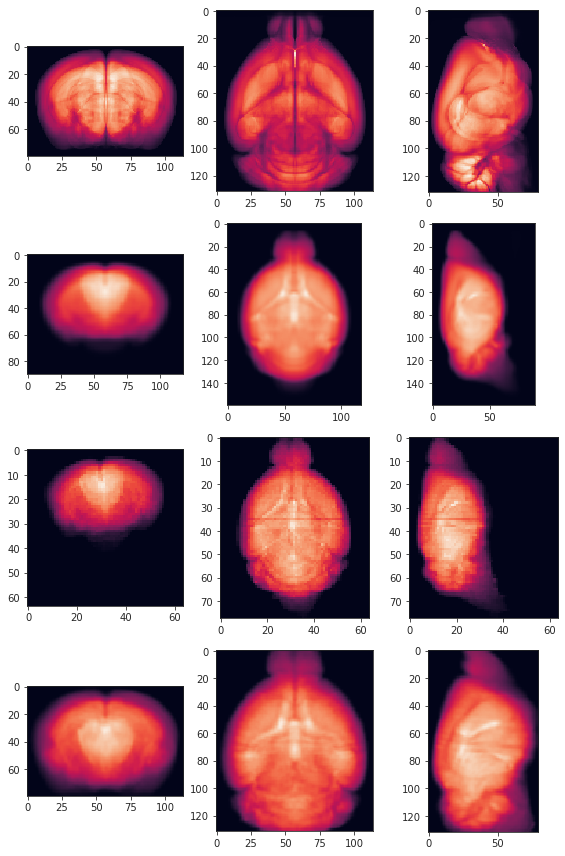

In [95]:
fig, axes = create_figure(4, 3, (8, 12))
for i in range(3):
    axes[0, i].imshow(temp.mean(i))
    axes[1, i].imshow(yale_n162_ants.mean(i))
    axes[2, i].imshow(moving.mean(i))
    axes[3, i].imshow(warped2.mean(i))

In [67]:
temp = mice.allen['template'].copy()
temp = reset_ants_img(temp, spacing=0.1)
temp.shape

(132, 80, 114)

In [68]:
temp

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (132, 80, 114)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [69]:
yale_n162_ants

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (160, 90, 118)
         Spacing    : (0.1, 0.1, 0.1)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

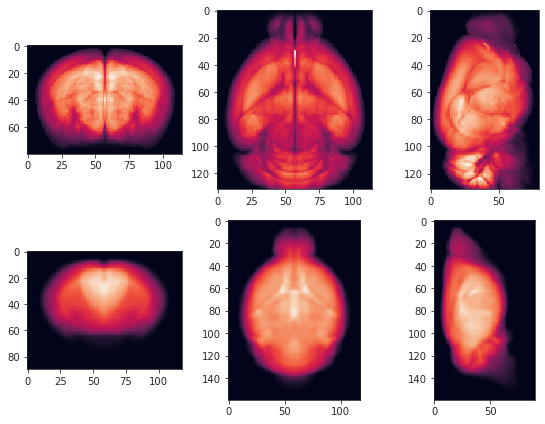

In [70]:
fig, axes = create_figure(2, 3, (8, 6))
for i in range(3):
    axes[0, i].imshow(temp.mean(i))
    axes[1, i].imshow(yale_n162_ants.mean(i))

In [378]:
_txs = []
_perf = []
for seed in tqdm(seeds):
    tx = ants.registration(
        fixed=temp,
        moving=fixed,
        mask=fixed.get_mask(),
        type_of_transform='SyN',
        verbose=True,
        random_seed=seed,
    )
    warped = ants.apply_transforms(
        fixed=temp,
        moving=fixed,
        transformlist=tx['fwdtransforms'],
        interpolator='linear',
    )
    mi = ants.image_mutual_information(temp, warped)
    mi_base = ants.image_mutual_information(temp, temp)
    _perf.append(mi / mi_base)
    _txs.append(tx)


  0%|          | 0/20 [00:00<?, ?it/s]

In [379]:
_perf

[
    0.07849137478717025,
    0.08474589653543613,
    0.4279977087687116,
    0.07870640206489452,
    0.428952599308624,
    0.07524416125094234,
    0.07760234045982159,
    0.42850732529454777,
    0.0069501886391655845,
    0.07687764942384909,
    0.07916476010907937,
    0.08043469947969412,
    0.08333666652569041,
    0.08737387679574354,
    0.0908598502420529,
    0.050674646777813574,
    0.08231525319203073,
    0.08032300093087444,
    0.42886511850341325,
    0.4286692814753021
]

In [380]:
_perf[np.argmax(_perf)]

0.428952599308624

In [250]:
ants.image_read(file)

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [248]:
ants.image_read(load)

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [249]:
ants.image_read(pjoin(mice.cfg.base_dir, 'test.nii.gz'))

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (66, 40, 57)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [251]:
ants.image_read(pjoin(mice.cfg.base_dir, 'overlay0.nii.gz'))

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [4]:
from register.atlas import get_subtree, included_intersect_tables
tree = load_bg_atlas().hierarchy

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [5]:
_ = get_subtree(
    tree,
    base_id=8,
    n_levels=3,
    show=True,
)

grey (8)
├── BS (343)
│   ├── HB (1065)
│   ├── IB (1129)
│   └── MB (313)
├── CB (512)
│   ├── CBN (519)
│   └── CBX (528)
└── CH (567)
    ├── CNU (623)
    └── CTX (688)



In [6]:
_ = get_subtree(
    tree,
    base_id=567,
    n_levels=4,
    show=True,
)

CH (567)
├── CNU (623)
│   ├── PAL (803)
│   │   ├── PALc (809)
│   │   ├── PALd (818)
│   │   ├── PALm (826)
│   │   └── PALv (835)
│   └── STR (477)
│       ├── LSX (275)
│       ├── STRd (485)
│       ├── STRv (493)
│       └── sAMY (278)
└── CTX (688)
    ├── CTXpl (695)
    │   ├── HPF (1089)
    │   ├── Isocortex (315)
    │   └── OLF (698)
    └── CTXsp (703)
        ├── BLA (295)
        ├── BMA (319)
        ├── CLA (583)
        ├── EP (942)
        ├── LA (131)
        └── PA (780)



In [7]:
cortex_subtree, base_lvl = get_subtree(
    tree,
    base_id=315,
    n_levels=2,
    show=True,
)

Isocortex (315)
├── ACA (31)
├── AI (95)
├── AUD (247)
├── ECT (895)
├── FRP (184)
├── GU (1057)
├── ILA (44)
├── MO (500)
├── ORB (714)
├── PERI (922)
├── PL (972)
├── PTLp (22)
├── RSP (254)
├── SS (453)
├── TEa (541)
├── VIS (669)
└── VISC (677)



In [8]:
_dir = '/home/hadi/Downloads/xilin'
os.listdir(_dir)

[
    'allcell_xilin_grand28_flip_symm.nii.gz',
    'mouseatlas_2020.json',
    'N162_medium_symm_0.2.nii.gz',
    'N162_finesc_symm_0.2.nii.gz',
    'N162_coarse_symm_0.2.nii.gz'
]

In [101]:
import json

with open(pjoin(_dir, 'mouseatlas_2020.json'), 'r') as f:
    atlas = json.load(f)

In [102]:
atlas['labels']['data'][1]['name']

'Mid-60'

In [103]:
mid_labels = atlas['labels']['data'][1]['labels']
mid_labels

{
    '1': 'R-Frontal pole, cerebral cortex (FRP,184)',
    '2': 'R-Somatomotor areas (MO,500)',
    '3': 'R-Somatosensory areas (SS,453)',
    '4': 'R-Gustatory areas (GU,1057)',
    '5': 'R-Visceral area (VISC,677)',
    '6': 'R-Auditory areas (AUD,247)',
    '7': 'R-Visual areas (VIS,669)',
    '8': 'R-Anterior cingulate area (ACA,31)',
    '9': 'R-Prelimbic area (PL,972)',
    '10': 'R-Infralimbic area (ILA,44)',
    '11': 'R-Orbital area (ORB,714)',
    '12': 'R-Agranular insular area (AI,95)',
    '13': 'R-Retrosplenial area (RSP,254)',
    '14': 'R-Posterior parietal association areas (PTLp,22)',
    '15': 'R-Temporal association areas (TEa,541)',
    '16': 'R-Perirhinal area (PERI,922)',
    '17': 'R-Ectorhinal area (ECT,895)',
    '18': 'R-Main olfactory bulb (MOB,507)',
    '19': 'R-Accessory olfactory bulb (AOB,151)',
    '20': 'R-Anterior olfactory nucleus (AON,159)',
    '21': 'R-Taenia tecta (TT,589)',
    '22': 'R-Dorsal peduncular area (DP,814)',
    '23': 'R-Piriform area (PIR,961)',
    '24': 'R-Nucleus of the lateral olfactory tract (NLOT,619)',
    '25': 'R-Cortical amygdalar area (COA,631)',
    '26': 'R-Piriform-amygdalar area (PAA,788)',
    '27': 'R-Postpiriform transition area (TR,566)',
    '28': 'R-Hippocampal region (HIP,1080)',
    '29': 'R-Retrohippocampal region (RHP,822)',
    '30': 'R-Claustrum (CLA,583)',
    '31': 'R-Endopiriform nucleus (EP,942)',
    '32': 'R-Lateral amygdalar nucleus (LA,131)',
    '33': 'R-Basolateral amygdalar nucleus (BLA,295)',
    '34': 'R-Basomedial amygdalar nucleus (BMA,319)',
    '35': 'R-Posterior amygdalar nucleus (PA,780)',
    '36': 'R-Striatum dorsal region (STRd,485)',
    '37': 'R-Striatum ventral region (STRv,493)',
    '38': 'R-Lateral septal complex (LSX,275)',
    '39': 'R-Striatum-like amygdalar nuclei (sAMY,278)',
    '40': 'R-Pallidum, dorsal region (PALd,818)',
    '41': 'R-Pallidum, ventral region (PALv,835)',
    '42': 'R-Pallidum, medial region (PALm,826)',
    '43': 'R-Pallidum, caudal region (PALc,809)',
    '44': 'R-Thalamus, sensory-motor cortex related (DORsm,864)',
    '45': 'R-Thalamus, polymodal association cortex related (DORpm,856)',
    '46': 'R-Periventricular zone (PVZ,157)',
    '47': 'R-Periventricular region (PVR,141)',
    '48': 'R-Hypothalamic medial zone (MEZ,467)',
    '49': 'R-Hypothalamic lateral zone (LZ,290)',
    '50': 'R-Midbrain, sensory related (MBsen,339)',
    '51': 'R-Midbrain, motor related (MBmot,323)',
    '52': 'R-Midbrain, behavioral state related (MBsta,348)',
    '53': 'R-Pons, sensory related (P-sen,1132)',
    '54': 'R-Pons, motor related (P-mot,987)',
    '55': 'R-Pons, behavioral state related (P-sat,1117)',
    '56': 'R-Medulla, sensory related (MY-sen,386)',
    '57': 'R-Medulla, motor related (MY-mot,370)',
    '58': 'R-Medulla, behavioral state related (MY-sat,379)',
    '59': 'R-Cerebellar cortex (CBX,528)',
    '60': 'R-Cerebellar nuclei (CBN,519)',
    '101': 'L-Frontal pole, cerebral cortex (FRP,184)',
    '102': 'L-Somatomotor areas (MO,500)',
    '103': 'L-Somatosensory areas (SS,453)',
    '104': 'L-Gustatory areas (GU,1057)',
    '105': 'L-Visceral area (VISC,677)',
    '106': 'L-Auditory areas (AUD,247)',
    '107': 'L-Visual areas (VIS,669)',
    '108': 'L-Anterior cingulate area (ACA,31)',
    '109': 'L-Prelimbic area (PL,972)',
    '110': 'L-Infralimbic area (ILA,44)',
    '111': 'L-Orbital area (ORB,714)',
    '112': 'L-Agranular insular area (AI,95)',
    '113': 'L-Retrosplenial area (RSP,254)',
    '114': 'L-Posterior parietal association areas (PTLp,22)',
    '115': 'L-Temporal association areas (TEa,541)',
    '116': 'L-Perirhinal area (PERI,922)',
    '117': 'L-Ectorhinal area (ECT,895)',
    '118': 'L-Main olfactory bulb (MOB,507)',
    '119': 'L-Accessory olfactory bulb (AOB,151)',
    '120': 'L-Anterior olfactory nucleus (AON,159)',
    '121': 'L-Taenia tecta (TT,589)',
    '122': 'L-Dorsal peduncular area (DP,814)',
    '123': 'L-Piriform area (PIR,961)',
    '124': 'L-Nucleus of

In [104]:
mid_acros = [s.split('(')[-1].split(',')[0] for s in mid_labels.values()]
mid_acros = list(set(mid_acros))
mid_structs = mice.allen['structure_tree'].get_structures_by_acronym(mid_acros)
mid_subcortical = [
    s['acronym'] for s in mid_structs
    if s['id'] not in cortex_subtree
]
len(mid_subcortical)

43

In [ ]:
43, 173

In [105]:
tables = included_intersect_tables(
    s_included=mid_subcortical,
    s_main=['BS', 'CB', 'CNU', 'HPF', 'OLF', 'CTXsp'],
    export_path=pjoin(tmp_dir, 'xilin_mid'),
    allen=mice.allen,
    tree=tree,
)

[PROGRESS] 'hierarchy_root-BS.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/xilin_mid

[PROGRESS] 'hierarchy_root-CB.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/xilin_mid

[PROGRESS] 'hierarchy_root-CNU.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/xilin_mid

[PROGRESS] 'hierarchy_root-HPF.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/xilin_mid

[PROGRESS] 'hierarchy_root-OLF.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/xilin_mid

[PROGRESS] 'hierarchy_root-CTXsp.html' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/xilin_mid

In [47]:
from bg_atlasapi import show_atlases
show_atlases()

                                                                                  
                                                                                  
                                Brainglobe Atlases                                
╭──────────────────────────────────┬────────────┬───────────────┬────────────────╮
│ Name                             │ Downloaded │ Local version │ Latest version │
├──────────────────────────────────┼────────────┼───────────────┼────────────────┤
│ allen_cord_20um                  │     ✔      │      1.0      │      1.0       │
│ mpin_zfish_1um                   │     ✔      │      1.0      │      1.0       │
│ example_mouse_100um              │     ✔      │      1.2      │      1.2       │
│ kim_mouse_100um                  │     ✔      │      1.0      │      1.0       │
│ allen_mouse_100um                │     ✔      │      1.2      │      1.2       │
│ allen_mouse_10um                 │    ---     │      ---      │      1.2       │
│ allen_mouse_25um                 │    ---     │      ---      │      1.2       │
│ allen_mouse_50um                 │    ---     │      ---      │      1.2       │
│ allen_human_500um                │    ---     │      ---      │      0.1       │
│ kim_mouse_10um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_25um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_50um                   │    ---     │      ---      │      1.0       │
│ osten_mouse_10um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_25um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_50um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_100um                │    ---     │      ---      │      1.1       │
╰──────────────────────────────────┴────────────┴───────────────┴────────────────╯

In [50]:
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
bg_atlas = BrainGlobeAtlas("kim_mouse_100um")

kim mouse atlas (res. 100um)
From: https://kimlab.io/brain-map/atlas/ (Chon et al. 2019, https://doi.org/10.1038/s41467-019-13057-w )


<matplotlib.image.AxesImage object at 0x7ffa9e690d90>

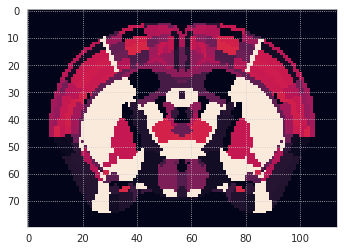

In [70]:
plt.imshow(bg_atlas.annotation[60], vmin=100, vmax=2000)

In [92]:
_ = get_subtree(
    tree = bg_atlas.hierarchy,
    base_id=485,
    n_levels=9,
    show=True,
)

STRd (485)
└── CP (672)
    ├── CPc (2496)
    │   ├── CPc, d (2493)
    │   │   ├── CPc, d, dl (2485)
    │   │   ├── CPc, d, dm (2484)
    │   │   └── CPc, d, vm (2486)
    │   ├── CPc, i (2494)
    │   │   ├── CPc, i, d (2487)
    │   │   ├── CPc, i, vl (2488)
    │   │   └── CPc, i, vm (2489)
    │   └── CPc, v (2490)
    ├── CPce (2495)
    ├── CPi (2492)
    │   ├── CPi, dl (2499)
    │   │   ├── CPi, dl, d (2300)
    │   │   └── CPi, dl, imd (2301)
    │   ├── CPi, dm (2498)
    │   │   ├── CPi, dm, cd (2374)
    │   │   ├── CPi, dm, dl (2299)
    │   │   ├── CPi, dm, dt (2380)
    │   │   └── CPi, dm, im (2298)
    │   ├── CPi, vl (2501)
    │   │   ├── CPi, vl, cvl (2370)
    │   │   ├── CPi, vl, imv (2479)
    │   │   ├── CPi, vl, v (2482)
    │   │   └── CPi, vl, vt (2481)
    │   └── CPi, vm (2500)
    │       ├── CPi, vm, cvm (2483)
    │       ├── CPi, vm, v (2480)
    │       └── CPi, vm, vm (2302)
    ├── CPr (2491)
    │   ├── CPr, imd (2295)
    │   ├── CPr, imv (2296

In [99]:
bg_atlas.structures[2374]

{
    'name': 'Caudoputamen- intermediate, dorsomedial, central dorsal',
    'acronym': 'CPi, dm, cd',
    'id': 2374,
    'structure_id_path': [997, 8, 567, 623, 477, 485, 672, 2492, 2498, 2374],
    'rgb_triplet': [255, 255, 255],
    'mesh_filename': PosixPath('/home/hadi/.brainglobe/kim_mouse_100um_v1.0/meshes/2374.obj'),
    'mesh': <meshio mesh object>
  Number of points: 4296
  Number of cells:
    triangle: 4300
}

In [98]:
bg_atlas.get_structure_descendants(485)

[
    'CP',
    'CPre',
    'CPr',
    'CPr, m',
    'CPr, imd',
    'CPr, imv',
    'CPr, l',
    'CPr, l, ls',
    'CPr, l, vm',
    'CPi',
    'CPi, dm',
    'CPi, dm, dl',
    'CPi, dm, im',
    'CPi, dm, cd',
    'CPi, dm, dt',
    'CPi, vm',
    'CPi, vm, vm',
    'CPi, vm, v',
    'CPi, vm, cvm',
    'CPi, dl',
    'CPi, dl, d',
    'CPi, dl, imd',
    'CPi, vl',
    'CPi, vl, imv',
    'CPi, vl, v',
    'CPi, vl, vt',
    'CPi, vl, cvl',
    'CPc',
    'CPc, d',
    'CPc, d, dm',
    'CPc, d, dl',
    'CPc, d, vm',
    'CPc, i',
    'CPc, i, d',
    'CPc, i, vm',
    'CPc, i, vl',
    'CPc, v',
    'CPce'
]

In [19]:
t = tables['BS']

In [20]:
html = t.get_html_string(
    header=True,
    border=True,
    format=True,
)

In [21]:
html

'<table frame="box" rules="cols">\n    <thead>\n        <tr>\n            <th style="padding-left: 1em; padding-right: 1em; text-align: center">lvl</th>\n            <th style="padding-left: 1em; padding-right: 1em; text-align: center">id</th>\n            <th style="padding-left: 1em; padding-right: 1em; text-align: center">acronym (name)</th>\n            <th style="padding-left: 1em; padding-right: 1em; text-align: center">parent</th>\n            <th style="padding-left: 1em; padding-right: 1em; text-align: center"># vox</th>\n            <th style="padding-left: 1em; padding-right: 1em; text-align: center">sz / cortex</th>\n        </tr>\n    </thead>\n    <tbody>\n        <tr>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n        </tr>\n        <tr>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">2</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">343</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">BS (Brain stem)</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">BS (Basic c...)</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">119632</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">97 %</td>\n        </tr>\n        <tr>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">---</td>\n        </tr>\n        <tr>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">3</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">1065</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">HB (Hindbrain)</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">HB (Brain stem)</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">47624</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">39 %</td>\n        </tr>\n        <tr>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">3</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: center; vertical-align: top">1129</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: top">IB (Interbrain)</td>\n            <td style="padding-left: 1em; padding-right: 1em; text-align: left; vertical-align: 

In [58]:
mice.cfg.include_regions

[
    'PALd',
    'PALv',
    'PALm',
    'PALc',
    'STRd',
    'STRv',
    'LSX',
    'sAMY',
    'MOB',
    'AOB',
    'AON',
    'TT',
    'DP',
    'PIR',
    'NLOT',
    'COA',
    'PAA',
    'TR',
    'CA',
    'DG',
    'ENTl',
    'ENTm',
    'PAR',
    'POST',
    'PRE',
    'SUB',
    'ProS',
    'HATA',
    'APr',
    'MY-sen',
    'MY-mot',
    'P-sen',
    'P-mot',
    'P-sat',
    'HY',
    'DORsm',
    'DORpm',
    'MBsen',
    'MBmot',
    'MBsta',
    'CBN',
    'VERM',
    'SIM',
    'AN',
    'PRM',
    'COPY',
    'PFL',
    'FL',
    'CTXsp',
    'Isocortex'
]

In [61]:
set(mid_subcortical).symmetric_difference(set(mice.cfg.include_regions))

{
    'SUB',
    'DG',
    'APr',
    'COPY',
    'BLA',
    'EP',
    'CTXsp',
    'FL',
    'PFL',
    'SIM',
    'CLA',
    'VERM',
    'LZ',
    'PRM',
    'HATA',
    'POST',
    'CA',
    'MEZ',
    'Isocortex',
    'HIP',
    'PVZ',
    'AN',
    'PVR',
    'ENTm',
    'RHP',
    'PAR',
    'PRE',
    'CBX',
    'HY',
    'PA',
    'BMA',
    'ENTl',
    'LA',
    'MY-sat',
    'ProS'
}

In [62]:
len(set(mid_subcortical).intersection(set(mice.cfg.include_regions)))

29

In [ ]:
len(set(mid_subcortical).intersection(set(mice.cfg.include_regions)))

In [60]:
mid_subcortical

[
    'STRv',
    'BLA',
    'EP',
    'P-sen',
    'PIR',
    'PALv',
    'LSX',
    'MY-sen',
    'TR',
    'MBsta',
    'CLA',
    'P-sat',
    'DP',
    'MY-mot',
    'DORpm',
    'NLOT',
    'LZ',
    'MEZ',
    'MBmot',
    'CBN',
    'HIP',
    'AOB',
    'AON',
    'PVZ',
    'PALm',
    'DORsm',
    'TT',
    'MOB',
    'PVR',
    'RHP',
    'PAA',
    'sAMY',
    'MBsen',
    'CBX',
    'PA',
    'P-mot',
    'PALc',
    'BMA',
    'STRd',
    'LA',
    'PALd',
    'MY-sat',
    'COA'
]

{
    'ILA',
    'FRP',
    'BLA',
    'EP',
    'PTLp',
    'SS',
    'CLA',
    'RSP',
    'GU',
    'ECT',
    'VIS',
    'PL',
    'LZ',
    'MO',
    'TEa',
    'MEZ',
    'HIP',
    'VISC',
    'PVZ',
    'AI',
    'PVR',
    'RHP',
    'CBX',
    'AUD',
    'PERI',
    'ORB',
    'PA',
    'BMA',
    'LA',
    'MY-sat',
    'ACA'
}

In [17]:
img = nib.load(pjoin(_dir, 'N162_medium_symm_0.2.nii.gz'))
arr = img.get_fdata()
arr.shape, arr.dtype

((60, 46, 81), dtype('float64'))

In [18]:
np.unique(arr)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116.,
       117., 118., 119., 120., 121., 122., 123., 124., 125., 126., 127.,
       128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
       139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 159., 160.])

In [15]:
mice.allen['template_info']['sizes']

array([132,  80, 114])

In [16]:
[a / b for a, b in zip(mice.allen['template_info']['sizes'], arr.shape)]

[2.2, 1.7391304347826086, 1.4074074074074074]